In [1]:
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from osgeo import osr, ogr, gdal
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np 

import tensorflow.keras
from tensorflow import keras
import os

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17678171690569317892
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1545338880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11498454840340293243
physical_device_desc: "device: 0, name: GeForce GTX 950, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [3]:
class My_Custom_Generator(keras.utils.Sequence) :
    "класс генератора для подачи нового набора каждую эпоху обучения"
    def __init__(self, batch_size, size, samples_in_file) : 
        self.batch_size = batch_size
        self.size = size
        self.samples_in_file = samples_in_file
        
        self.index = 0
        self.create_set()
    
    
    def __len__(self) :
        return (np.ceil(self.samples_in_file / float(self.batch_size))).astype(np.int)
    
    def create_set(self):
        self.target = None
        self.target = pd.read_csv(f"mask_last_Frame_{self.index}.csv")  
        self.target = np.array(self.target, dtype='f') 
        self.target = np.reshape(self.target, (-1, self.size, self.size, 1))
        self.target = self.target / 255.0
        
        self.train = None
        self.train = pd.read_csv(f"B5_Frame_{self.index}.csv")  
        self.train = np.array(self.train, dtype='f') 
        self.train = np.reshape(self.train, (-1, self.size, self.size, 1))     
        self.train = np.repeat(self.train, 3)
        self.train = np.reshape(self.train, (-1, self.size, self.size, 3))  
        self.train = self.train / 255.0
  
  
    def __getitem__(self, idx) : 
        
        if idx == 0:
            self.index +=1
            self.create_set()
            print("\n index = ", self.index) 
            if self.index == 39:
                self.index = 0

        
        target = self.target[idx * self.batch_size : (idx+1) * self.batch_size]
        train = self.train[idx * self.batch_size : (idx+1) * self.batch_size] 

            
        return train, target

In [4]:
def create_mask(pred_mask):
    "функция для обработки преобразования сети"
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


In [5]:
def split_image_old(path, size, save_path=None):
    "разбиение изображения на части для подачи в сеть для предсказания "
    img = Image.open(path).convert('L') 
    x, y = img.size  # ширина (x) и высота (y) изображения
    
    x = x // size
    y = y // size

    all_data = [] 

    for i in range(x):
        for j in range(y): 
            mini_image = img.crop(box=(size * i, size * j, size * (i + 1), size * ( j + 1)))
            if save_path:
                mini_image.save(save_path + 'image{}.png'.format(str(j + i*y)))

            mini_image = np.array(mini_image.getdata())
            mini_image = np.reshape(mini_image, (1, size, size, 1)) 

            if len(all_data) == 0:
                all_data =  mini_image
            else:
                all_data = np.append(all_data, mini_image, axis=0)
         
    return all_data, [x, y]

In [6]:
def show_predictions(dataset=None, num=1):
    "вывод результата предсказания"
    path_train = "files 4/B5.png" 
    size = 64
    test_image, test_image_size = split_image_old(path_train, size) 
    test_image = test_image / 255.0
    
    img = Image.new('L', (size*test_image_size[0], size*test_image_size[1]))

    for i in tqdm(range(test_image_size[0])):
        for j in range(test_image_size[1]):

            a = test_image[i * test_image_size[1] + j]
            a = np.repeat(a, 3)        
            b = np.reshape(a, (1, size, size, 3))
            prediction = model.predict(b)
            prediction = prediction # * 10000

    #         b, c = np.array_split(prediction, 2, axis = 3)
            train_img = create_mask(prediction)
            train_img = np.array(train_img) 

            train_img = np.reshape(train_img, (size, size )) 
            a = train_img.astype('uint8') 
            a = a * 256
            img1 =  Image.fromarray(a)
            img.paste(img1, (i*size, j*size))

    plt.imshow(img) 
    plt.show()


In [7]:
class DisplayCallback(tf.keras.callbacks.Callback):
    "класс для вывода предсказания в конце каждой эпохи"
    def on_epoch_end(self, epoch, logs=None):  
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


In [8]:
# параметры
batch_size = 64
size = 64
samples_in_file = 15834
my_training_batch_generator = My_Custom_Generator(batch_size, size, samples_in_file) 

In [9]:
# объявление модели

In [30]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[size, size, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


In [31]:
from tensorflow_examples.models.pix2pix import pix2pix

In [32]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [33]:
def unet_model(output_channels, size):
    inputs = tf.keras.layers.Input(shape=[size, size, 3])

  # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [34]:
from tensorflow.keras.optimizers import Adam
opt = Adam( )

In [35]:
OUTPUT_CHANNELS = 2
model = unet_model(OUTPUT_CHANNELS, size)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


/home/valter/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1945: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '



 index =  1
Epoch 1/251

 index =  2
247/247 [==============================] - 65s 122ms/step - loss: 0.0822 - accuracy: 0.9819


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


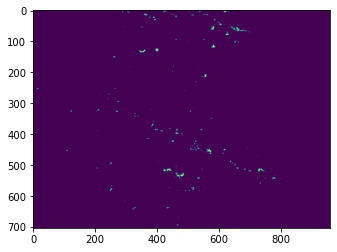


Sample Prediction after epoch 1

Epoch 2/251

 index =  3
247/247 [==============================] - 45s 122ms/step - loss: 0.0299 - accuracy: 0.9840


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


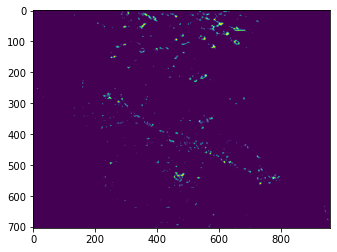


Sample Prediction after epoch 2

Epoch 3/251

 index =  4
247/247 [==============================] - 45s 122ms/step - loss: 0.0211 - accuracy: 0.9859


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


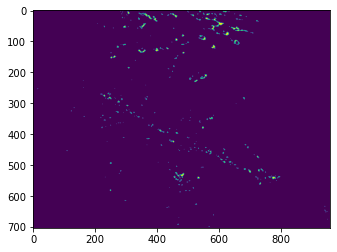


Sample Prediction after epoch 3

Epoch 4/251

 index =  5
247/247 [==============================] - 45s 122ms/step - loss: 0.0172 - accuracy: 0.9867


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


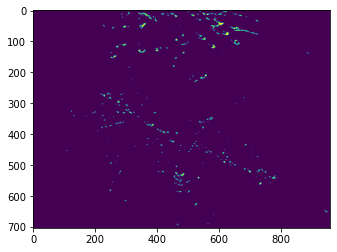


Sample Prediction after epoch 4

Epoch 5/251

 index =  6
247/247 [==============================] - 43s 122ms/step - loss: 0.0122 - accuracy: 0.9905


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


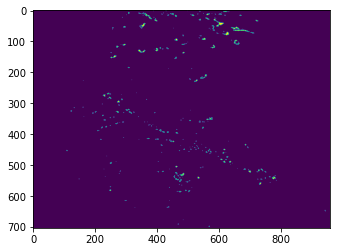


Sample Prediction after epoch 5

Epoch 6/251

 index =  7
247/247 [==============================] - 44s 122ms/step - loss: 0.0095 - accuracy: 0.9951


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


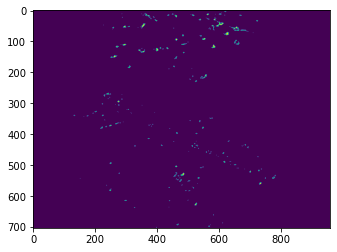


Sample Prediction after epoch 6

Epoch 7/251

 index =  8
247/247 [==============================] - 44s 122ms/step - loss: 0.0059 - accuracy: 0.9967


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


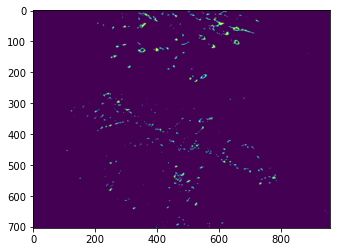


Sample Prediction after epoch 7

Epoch 8/251

 index =  9
247/247 [==============================] - 45s 122ms/step - loss: 0.0079 - accuracy: 0.9956


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


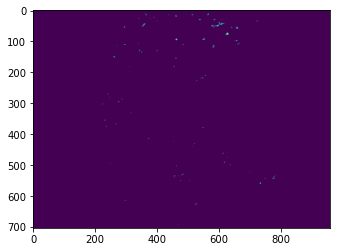


Sample Prediction after epoch 8

Epoch 9/251

 index =  10
247/247 [==============================] - 44s 122ms/step - loss: 0.0089 - accuracy: 0.9954


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


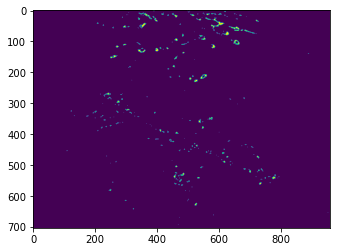


Sample Prediction after epoch 9

Epoch 10/251

 index =  11
247/247 [==============================] - 44s 122ms/step - loss: 0.0054 - accuracy: 0.9957


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


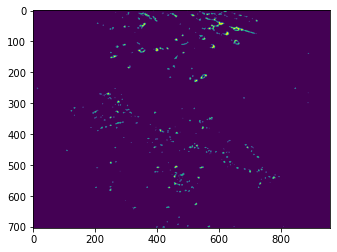


Sample Prediction after epoch 10

Epoch 11/251

 index =  12
247/247 [==============================] - 45s 122ms/step - loss: 0.0139 - accuracy: 0.9951


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


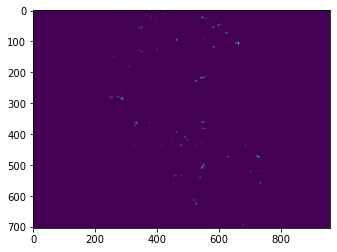


Sample Prediction after epoch 11

Epoch 12/251

 index =  13
247/247 [==============================] - 44s 122ms/step - loss: 0.0349 - accuracy: 0.9917


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


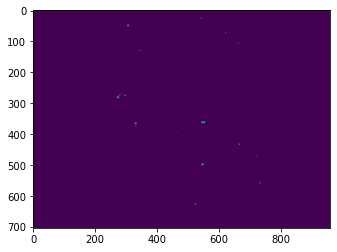


Sample Prediction after epoch 12

Epoch 13/251

 index =  14
247/247 [==============================] - 44s 122ms/step - loss: 0.0295 - accuracy: 0.9905


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


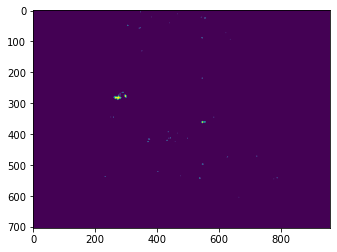


Sample Prediction after epoch 13

Epoch 14/251

 index =  15
247/247 [==============================] - 44s 122ms/step - loss: 0.0336 - accuracy: 0.9899


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


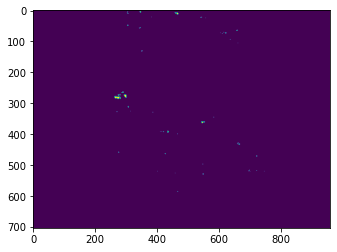


Sample Prediction after epoch 14

Epoch 15/251

 index =  16
247/247 [==============================] - 45s 122ms/step - loss: 0.0279 - accuracy: 0.9931


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


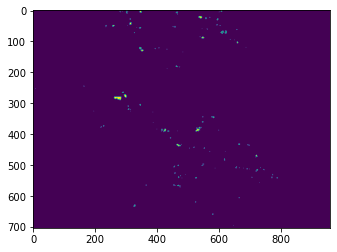


Sample Prediction after epoch 15

Epoch 16/251

 index =  17
247/247 [==============================] - 44s 122ms/step - loss: 0.0516 - accuracy: 0.9893


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


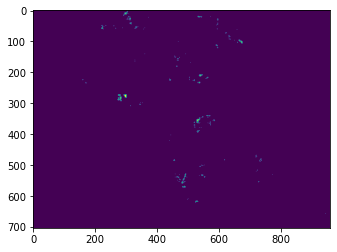


Sample Prediction after epoch 16

Epoch 17/251

 index =  18
247/247 [==============================] - 45s 122ms/step - loss: 0.0790 - accuracy: 0.9742


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


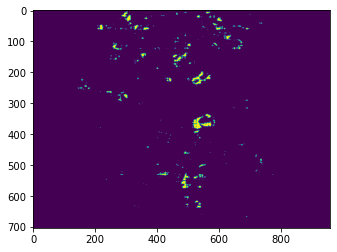


Sample Prediction after epoch 17

Epoch 18/251

 index =  19
247/247 [==============================] - 45s 122ms/step - loss: 0.0619 - accuracy: 0.9657


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


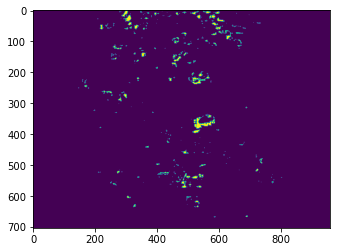


Sample Prediction after epoch 18

Epoch 19/251

 index =  20
247/247 [==============================] - 45s 122ms/step - loss: 0.0430 - accuracy: 0.9665


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


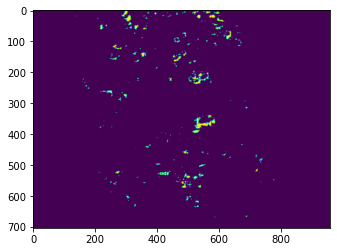


Sample Prediction after epoch 19

Epoch 20/251

 index =  21
247/247 [==============================] - 46s 122ms/step - loss: 0.0476 - accuracy: 0.9775


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


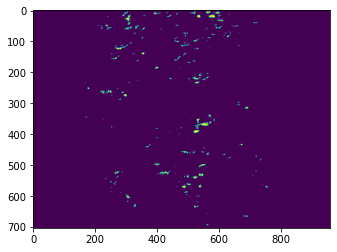


Sample Prediction after epoch 20

Epoch 21/251

 index =  22
247/247 [==============================] - 45s 122ms/step - loss: 0.0267 - accuracy: 0.9910


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


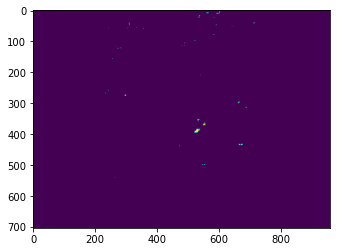


Sample Prediction after epoch 21

Epoch 22/251

 index =  23
247/247 [==============================] - 45s 122ms/step - loss: 0.0245 - accuracy: 0.9952


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


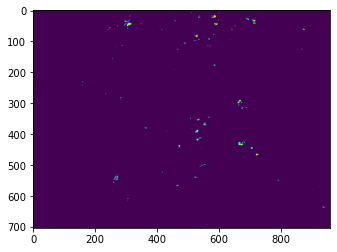


Sample Prediction after epoch 22

Epoch 23/251

 index =  24
247/247 [==============================] - 45s 122ms/step - loss: 0.0245 - accuracy: 0.9934


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


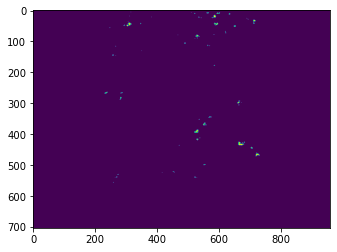


Sample Prediction after epoch 23

Epoch 24/251

 index =  25
247/247 [==============================] - 45s 122ms/step - loss: 0.0179 - accuracy: 0.9950


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


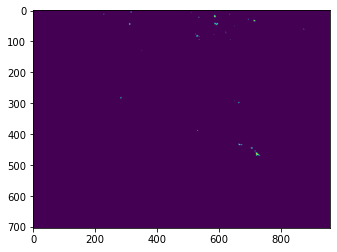


Sample Prediction after epoch 24

Epoch 25/251

 index =  26
247/247 [==============================] - 45s 122ms/step - loss: 0.0186 - accuracy: 0.9957


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


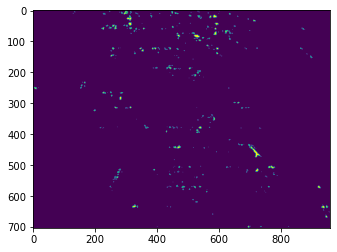


Sample Prediction after epoch 25

Epoch 26/251

 index =  27
247/247 [==============================] - 44s 122ms/step - loss: 0.0164 - accuracy: 0.9956


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


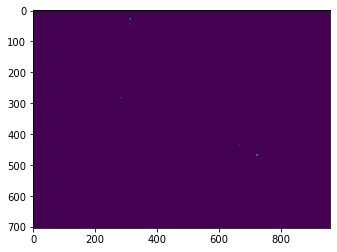


Sample Prediction after epoch 26

Epoch 27/251

 index =  28
247/247 [==============================] - 46s 122ms/step - loss: 0.0105 - accuracy: 0.9954


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


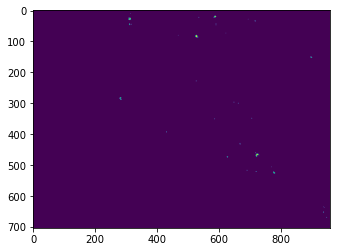


Sample Prediction after epoch 27

Epoch 28/251

 index =  29
247/247 [==============================] - 45s 122ms/step - loss: 0.0089 - accuracy: 0.9953


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


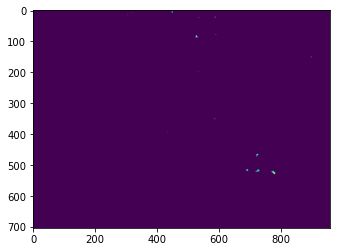


Sample Prediction after epoch 28

Epoch 29/251

 index =  30
247/247 [==============================] - 44s 122ms/step - loss: 0.0056 - accuracy: 0.9988


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


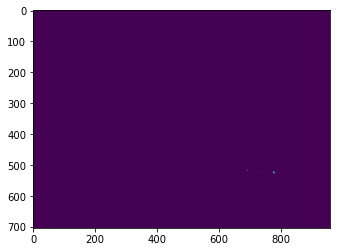


Sample Prediction after epoch 29

Epoch 30/251

 index =  31
247/247 [==============================] - 46s 122ms/step - loss: 3.5082e-04 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


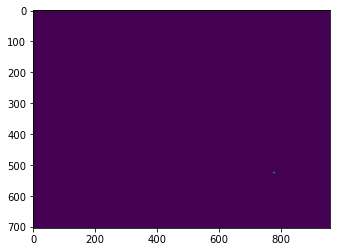


Sample Prediction after epoch 30

Epoch 31/251

 index =  32
247/247 [==============================] - 44s 122ms/step - loss: 3.6085e-05 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


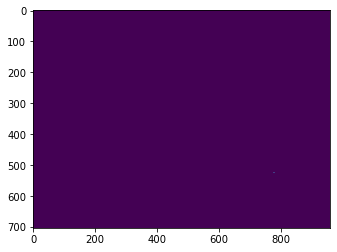


Sample Prediction after epoch 31

Epoch 32/251

 index =  33
247/247 [==============================] - 44s 122ms/step - loss: 4.5412e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


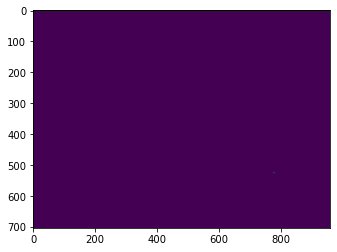


Sample Prediction after epoch 32

Epoch 33/251

 index =  34
247/247 [==============================] - 44s 122ms/step - loss: 3.0947e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


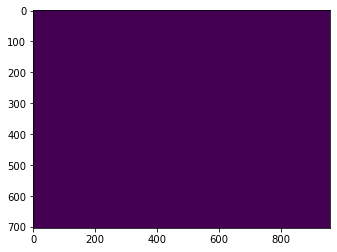


Sample Prediction after epoch 33

Epoch 34/251

 index =  35
247/247 [==============================] - 45s 122ms/step - loss: 2.4814e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


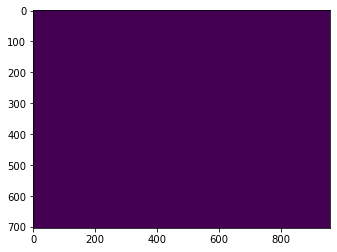


Sample Prediction after epoch 34

Epoch 35/251

 index =  36
247/247 [==============================] - 44s 122ms/step - loss: 2.2989e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


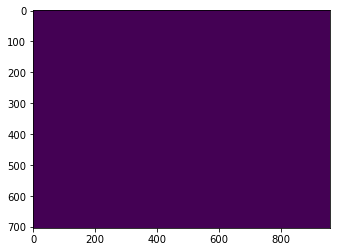


Sample Prediction after epoch 35

Epoch 36/251

 index =  37
247/247 [==============================] - 45s 121ms/step - loss: 1.7288e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


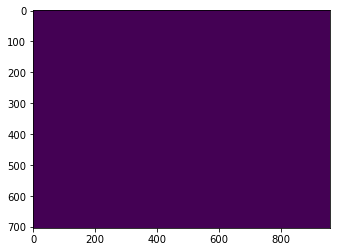


Sample Prediction after epoch 36

Epoch 37/251

 index =  38
247/247 [==============================] - 44s 122ms/step - loss: 1.3191e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


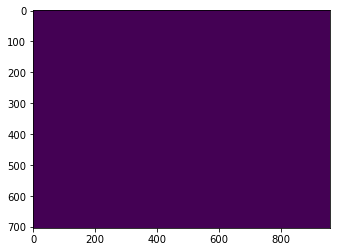


Sample Prediction after epoch 37

Epoch 38/251

 index =  39
247/247 [==============================] - 45s 121ms/step - loss: 1.1753e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


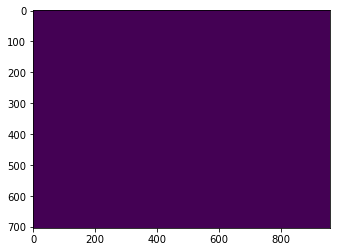


Sample Prediction after epoch 38

Epoch 39/251

 index =  1
247/247 [==============================] - 43s 122ms/step - loss: 0.0623 - accuracy: 0.9736


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


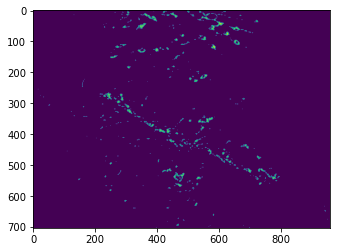


Sample Prediction after epoch 39

Epoch 40/251

 index =  2
247/247 [==============================] - 45s 121ms/step - loss: 0.0477 - accuracy: 0.9752


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


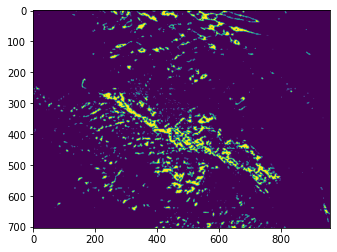


Sample Prediction after epoch 40

Epoch 41/251

 index =  3
247/247 [==============================] - 43s 121ms/step - loss: 0.0390 - accuracy: 0.9801


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


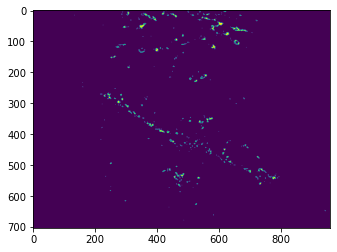


Sample Prediction after epoch 41

Epoch 42/251

 index =  4
247/247 [==============================] - 44s 121ms/step - loss: 0.0201 - accuracy: 0.9846


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


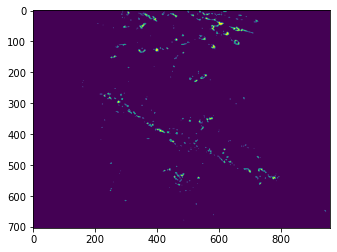


Sample Prediction after epoch 42

Epoch 43/251

 index =  5
247/247 [==============================] - 45s 122ms/step - loss: 0.0186 - accuracy: 0.9862


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


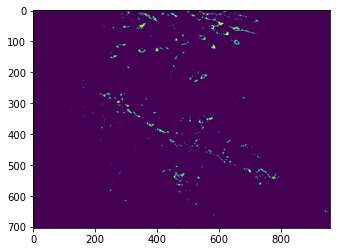


Sample Prediction after epoch 43

Epoch 44/251

 index =  6
247/247 [==============================] - 44s 122ms/step - loss: 0.0127 - accuracy: 0.9902


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


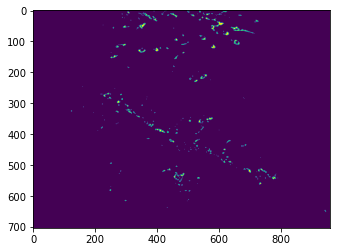


Sample Prediction after epoch 44

Epoch 45/251

 index =  7
247/247 [==============================] - 45s 122ms/step - loss: 0.0070 - accuracy: 0.9942


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


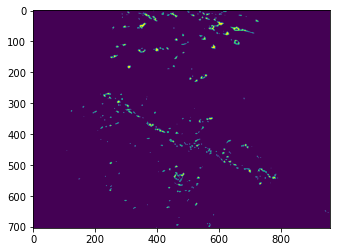


Sample Prediction after epoch 45

Epoch 46/251

 index =  8
247/247 [==============================] - 43s 122ms/step - loss: 0.0049 - accuracy: 0.9960


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


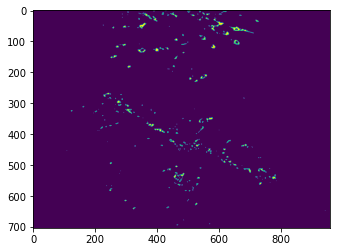


Sample Prediction after epoch 46

Epoch 47/251

 index =  9
247/247 [==============================] - 45s 122ms/step - loss: 0.0059 - accuracy: 0.9951


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


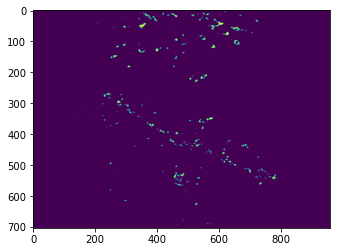


Sample Prediction after epoch 47

Epoch 48/251

 index =  10
247/247 [==============================] - 44s 122ms/step - loss: 0.0062 - accuracy: 0.9945


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


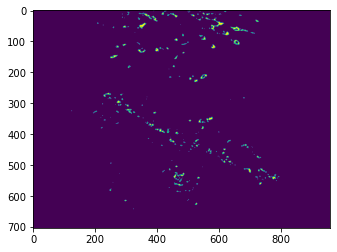


Sample Prediction after epoch 48

Epoch 49/251

 index =  11
247/247 [==============================] - 44s 122ms/step - loss: 0.0048 - accuracy: 0.9955


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


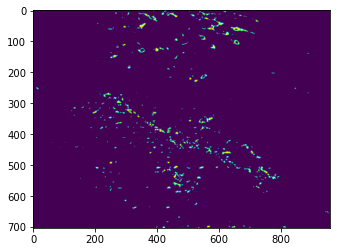


Sample Prediction after epoch 49

Epoch 50/251

 index =  12
247/247 [==============================] - 44s 122ms/step - loss: 0.0174 - accuracy: 0.9939


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


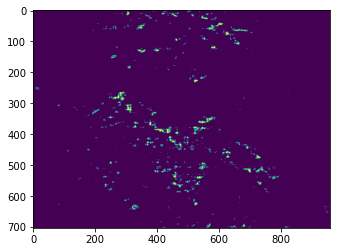


Sample Prediction after epoch 50

Epoch 51/251

 index =  13
247/247 [==============================] - 44s 122ms/step - loss: 0.0274 - accuracy: 0.9899


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


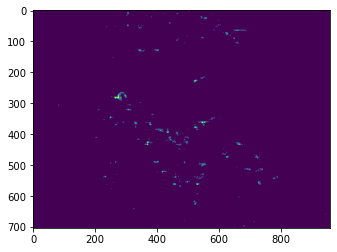


Sample Prediction after epoch 51

Epoch 52/251

 index =  14
247/247 [==============================] - 44s 122ms/step - loss: 0.0250 - accuracy: 0.9891


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


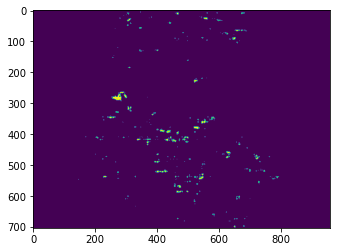


Sample Prediction after epoch 52

Epoch 53/251

 index =  15
247/247 [==============================] - 44s 122ms/step - loss: 0.0190 - accuracy: 0.9886


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


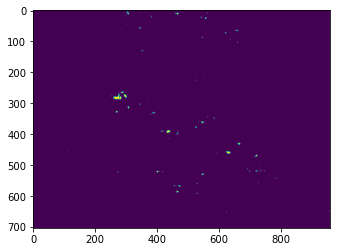


Sample Prediction after epoch 53

Epoch 54/251

 index =  16
247/247 [==============================] - 45s 122ms/step - loss: 0.0257 - accuracy: 0.9907


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


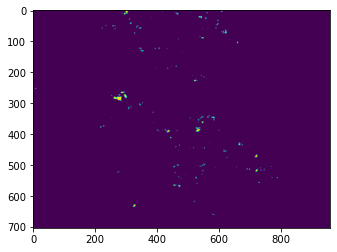


Sample Prediction after epoch 54

Epoch 55/251

 index =  17
247/247 [==============================] - 44s 122ms/step - loss: 0.0358 - accuracy: 0.9868


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


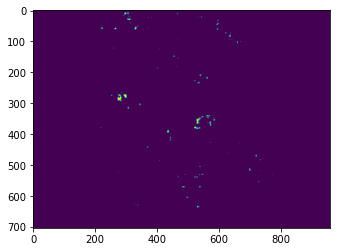


Sample Prediction after epoch 55

Epoch 56/251

 index =  18
247/247 [==============================] - 45s 122ms/step - loss: 0.0523 - accuracy: 0.9709


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


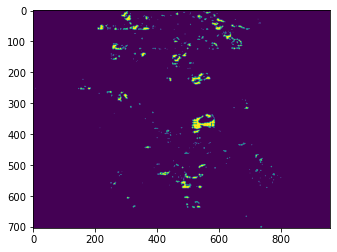


Sample Prediction after epoch 56

Epoch 57/251

 index =  19
247/247 [==============================] - 45s 122ms/step - loss: 0.0463 - accuracy: 0.9622


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


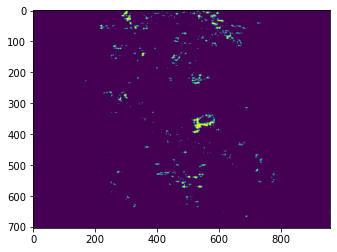


Sample Prediction after epoch 57

Epoch 58/251

 index =  20
247/247 [==============================] - 45s 122ms/step - loss: 0.0342 - accuracy: 0.9649


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


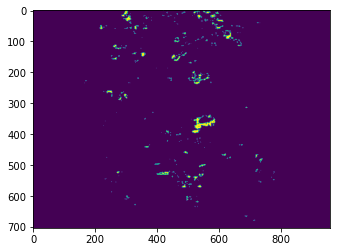


Sample Prediction after epoch 58

Epoch 59/251

 index =  21
247/247 [==============================] - 45s 122ms/step - loss: 0.0374 - accuracy: 0.9757


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


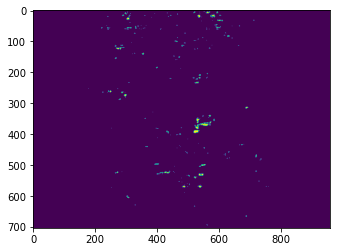


Sample Prediction after epoch 59

Epoch 60/251

 index =  22
247/247 [==============================] - 45s 122ms/step - loss: 0.0236 - accuracy: 0.9894


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


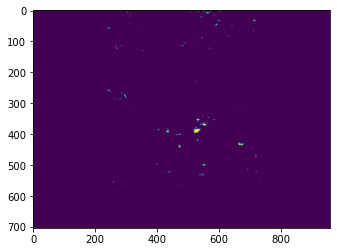


Sample Prediction after epoch 60

Epoch 61/251

 index =  23
247/247 [==============================] - 44s 122ms/step - loss: 0.0222 - accuracy: 0.9936


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


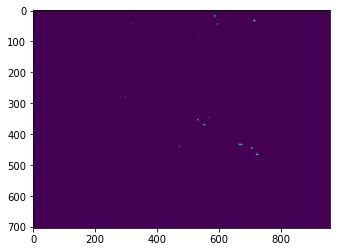


Sample Prediction after epoch 61

Epoch 62/251

 index =  24
247/247 [==============================] - 44s 122ms/step - loss: 0.0229 - accuracy: 0.9924


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


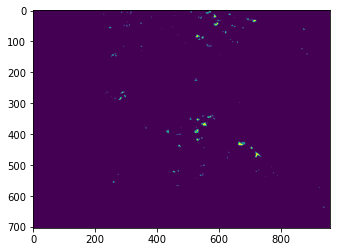


Sample Prediction after epoch 62

Epoch 63/251

 index =  25
247/247 [==============================] - 44s 122ms/step - loss: 0.0152 - accuracy: 0.9942


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


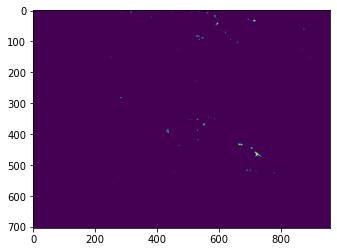


Sample Prediction after epoch 63

Epoch 64/251

 index =  26
247/247 [==============================] - 44s 122ms/step - loss: 0.0168 - accuracy: 0.9950


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


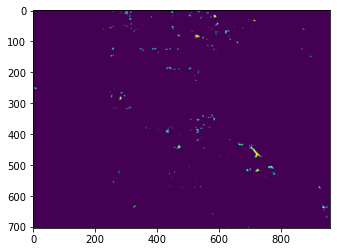


Sample Prediction after epoch 64

Epoch 65/251

 index =  27
247/247 [==============================] - 45s 122ms/step - loss: 0.0141 - accuracy: 0.9945


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


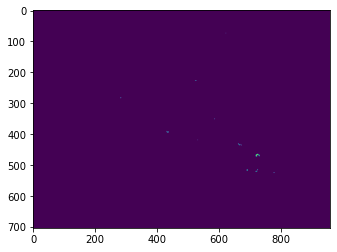


Sample Prediction after epoch 65

Epoch 66/251

 index =  28
247/247 [==============================] - 44s 122ms/step - loss: 0.0089 - accuracy: 0.9947


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


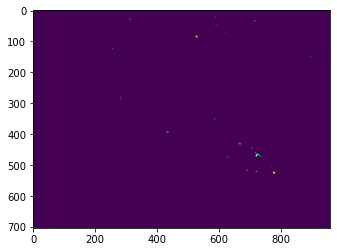


Sample Prediction after epoch 66

Epoch 67/251

 index =  29
247/247 [==============================] - 44s 122ms/step - loss: 0.0079 - accuracy: 0.9948


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


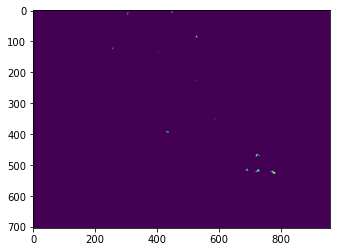


Sample Prediction after epoch 67

Epoch 68/251

 index =  30
247/247 [==============================] - 44s 122ms/step - loss: 0.0053 - accuracy: 0.9985


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


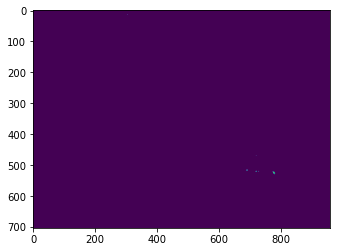


Sample Prediction after epoch 68

Epoch 69/251

 index =  31
247/247 [==============================] - 45s 122ms/step - loss: 3.2097e-04 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


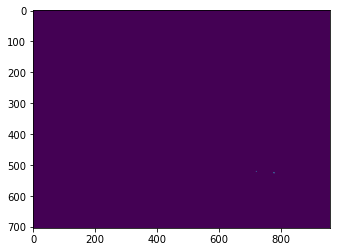


Sample Prediction after epoch 69

Epoch 70/251

 index =  32
247/247 [==============================] - 46s 122ms/step - loss: 3.4379e-05 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


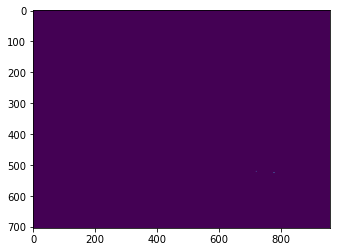


Sample Prediction after epoch 70

Epoch 71/251

 index =  33
247/247 [==============================] - 44s 122ms/step - loss: 3.9671e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


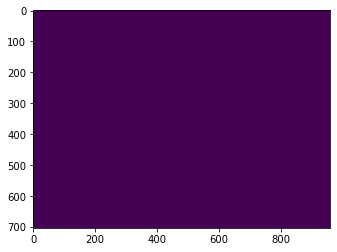


Sample Prediction after epoch 71

Epoch 72/251

 index =  34
247/247 [==============================] - 44s 122ms/step - loss: 2.6806e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


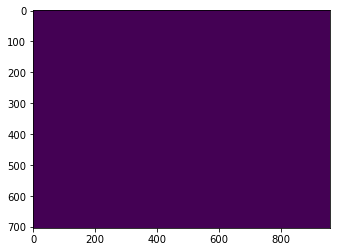


Sample Prediction after epoch 72

Epoch 73/251

 index =  35
247/247 [==============================] - 46s 122ms/step - loss: 1.7113e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


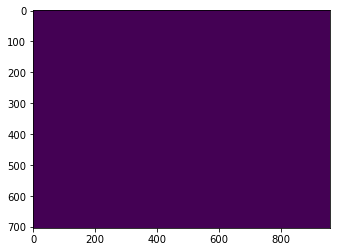


Sample Prediction after epoch 73

Epoch 74/251

 index =  36
247/247 [==============================] - 46s 122ms/step - loss: 1.6862e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


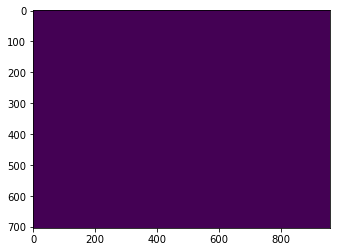


Sample Prediction after epoch 74

Epoch 75/251

 index =  37
247/247 [==============================] - 46s 122ms/step - loss: 1.1225e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


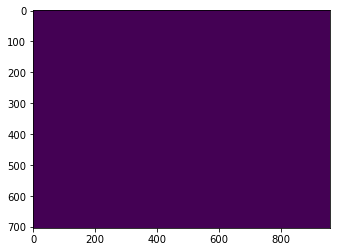


Sample Prediction after epoch 75

Epoch 76/251

 index =  38
247/247 [==============================] - 44s 122ms/step - loss: 6.7774e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


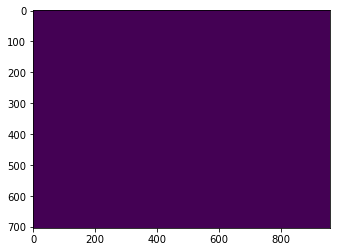


Sample Prediction after epoch 76

Epoch 77/251

 index =  39
247/247 [==============================] - 44s 122ms/step - loss: 5.9041e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


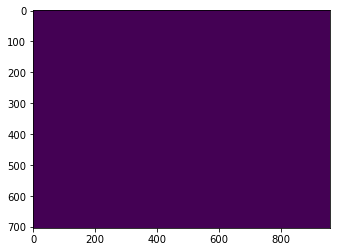


Sample Prediction after epoch 77

Epoch 78/251

 index =  1
247/247 [==============================] - 44s 122ms/step - loss: 0.0684 - accuracy: 0.9724


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


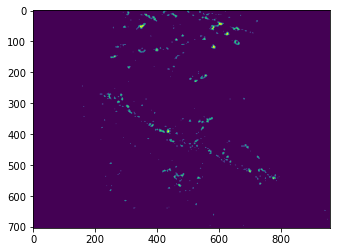


Sample Prediction after epoch 78

Epoch 79/251

 index =  2
247/247 [==============================] - 44s 122ms/step - loss: 0.0463 - accuracy: 0.9749


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


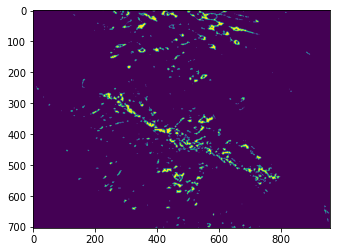


Sample Prediction after epoch 79

Epoch 80/251

 index =  3
247/247 [==============================] - 44s 122ms/step - loss: 0.0292 - accuracy: 0.9797


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


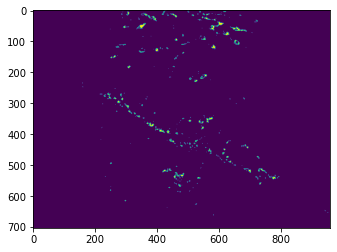


Sample Prediction after epoch 80

Epoch 81/251

 index =  4
247/247 [==============================] - 44s 122ms/step - loss: 0.0196 - accuracy: 0.9844


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


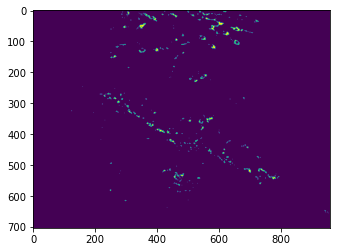


Sample Prediction after epoch 81

Epoch 82/251

 index =  5
247/247 [==============================] - 44s 122ms/step - loss: 0.0184 - accuracy: 0.9861


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


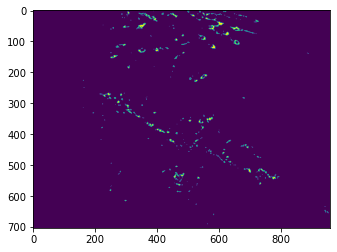


Sample Prediction after epoch 82

Epoch 83/251

 index =  6
247/247 [==============================] - 44s 121ms/step - loss: 0.0122 - accuracy: 0.9900


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


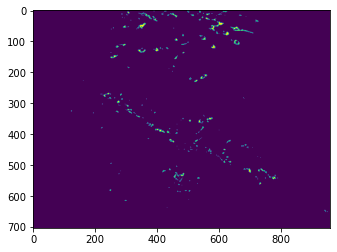


Sample Prediction after epoch 83

Epoch 84/251

 index =  7
247/247 [==============================] - 43s 122ms/step - loss: 0.0067 - accuracy: 0.9941


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


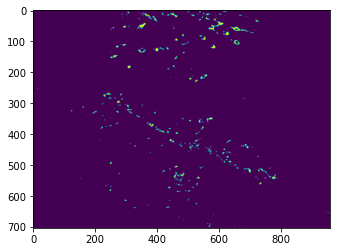


Sample Prediction after epoch 84

Epoch 85/251

 index =  8
247/247 [==============================] - 44s 122ms/step - loss: 0.0047 - accuracy: 0.9959


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


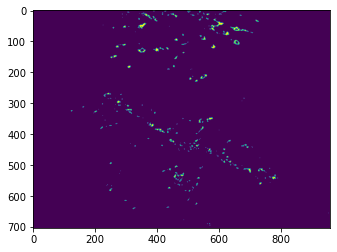


Sample Prediction after epoch 85

Epoch 86/251

 index =  9
247/247 [==============================] - 44s 122ms/step - loss: 0.0056 - accuracy: 0.9950


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


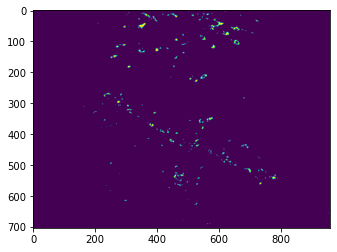


Sample Prediction after epoch 86

Epoch 87/251

 index =  10
247/247 [==============================] - 43s 122ms/step - loss: 0.0057 - accuracy: 0.9944


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


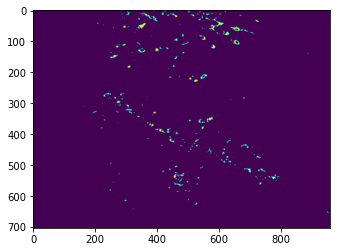


Sample Prediction after epoch 87

Epoch 88/251

 index =  11
247/247 [==============================] - 44s 122ms/step - loss: 0.0044 - accuracy: 0.9955


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


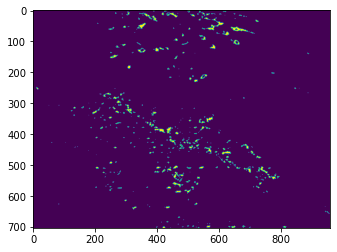


Sample Prediction after epoch 88

Epoch 89/251

 index =  12
247/247 [==============================] - 44s 122ms/step - loss: 0.0158 - accuracy: 0.9935


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


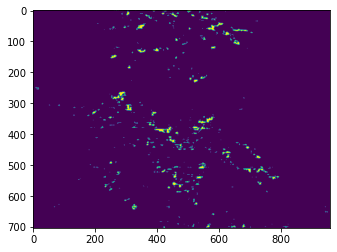


Sample Prediction after epoch 89

Epoch 90/251

 index =  13
247/247 [==============================] - 44s 122ms/step - loss: 0.0191 - accuracy: 0.9896


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


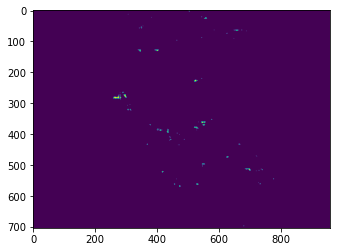


Sample Prediction after epoch 90

Epoch 91/251

 index =  14
247/247 [==============================] - 44s 122ms/step - loss: 0.0207 - accuracy: 0.9886


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


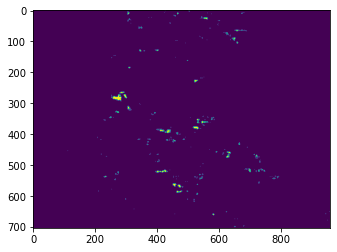


Sample Prediction after epoch 91

Epoch 92/251

 index =  15
247/247 [==============================] - 44s 122ms/step - loss: 0.0183 - accuracy: 0.9875


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


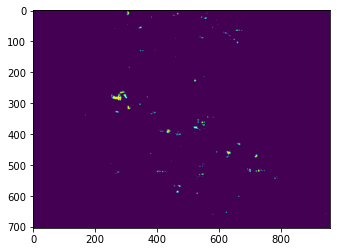


Sample Prediction after epoch 92

Epoch 93/251

 index =  16
247/247 [==============================] - 44s 122ms/step - loss: 0.0199 - accuracy: 0.9899


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


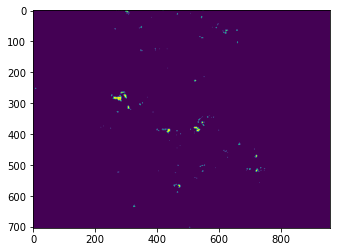


Sample Prediction after epoch 93

Epoch 94/251

 index =  17
247/247 [==============================] - 44s 122ms/step - loss: 0.0293 - accuracy: 0.9848


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


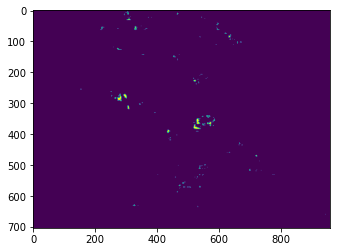


Sample Prediction after epoch 94

Epoch 95/251

 index =  18
247/247 [==============================] - 45s 122ms/step - loss: 0.0373 - accuracy: 0.9692


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


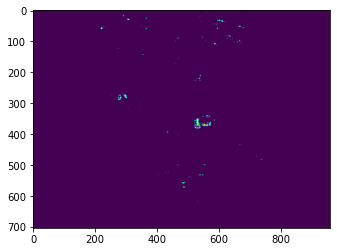


Sample Prediction after epoch 95

Epoch 96/251

 index =  19
247/247 [==============================] - 44s 122ms/step - loss: 0.0555 - accuracy: 0.9626


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


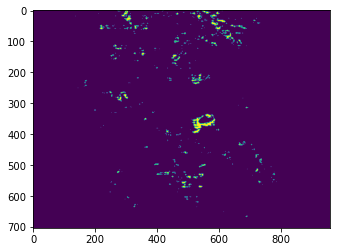


Sample Prediction after epoch 96

Epoch 97/251

 index =  20
247/247 [==============================] - 45s 122ms/step - loss: 0.0288 - accuracy: 0.9637


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


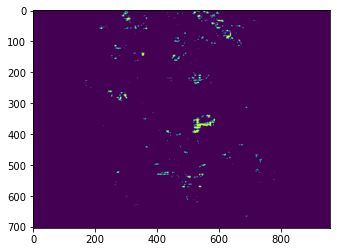


Sample Prediction after epoch 97

Epoch 98/251

 index =  21
247/247 [==============================] - 45s 122ms/step - loss: 0.0357 - accuracy: 0.9745


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


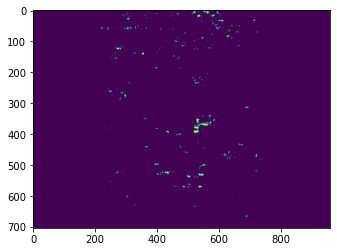


Sample Prediction after epoch 98

Epoch 99/251

 index =  22
247/247 [==============================] - 46s 122ms/step - loss: 0.0210 - accuracy: 0.9883


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


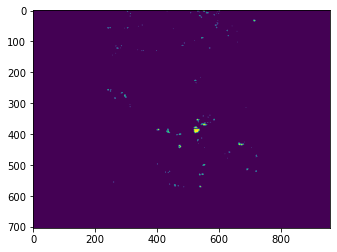


Sample Prediction after epoch 99

Epoch 100/251

 index =  23
247/247 [==============================] - 44s 122ms/step - loss: 0.0193 - accuracy: 0.9927


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


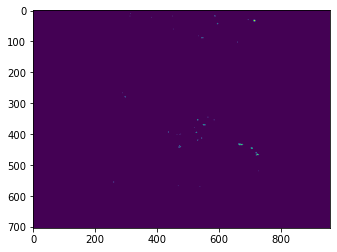


Sample Prediction after epoch 100

Epoch 101/251

 index =  24
247/247 [==============================] - 45s 122ms/step - loss: 0.0204 - accuracy: 0.9916


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


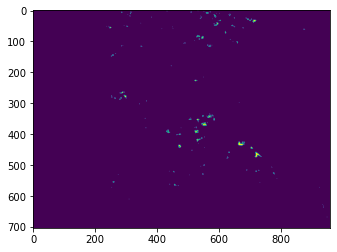


Sample Prediction after epoch 101

Epoch 102/251

 index =  25
247/247 [==============================] - 46s 122ms/step - loss: 0.0139 - accuracy: 0.9937


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


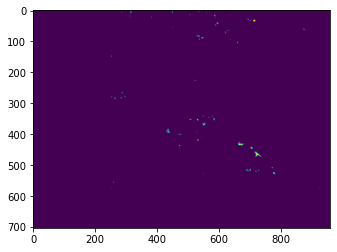


Sample Prediction after epoch 102

Epoch 103/251

 index =  26
247/247 [==============================] - 46s 122ms/step - loss: 0.0156 - accuracy: 0.9943


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


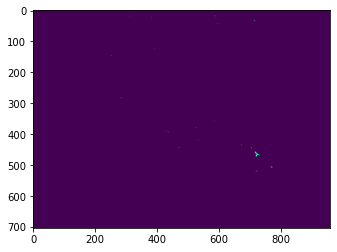


Sample Prediction after epoch 103

Epoch 104/251

 index =  27
247/247 [==============================] - 44s 122ms/step - loss: 0.0123 - accuracy: 0.9942


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


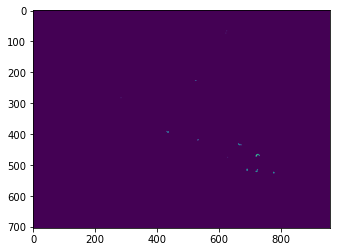


Sample Prediction after epoch 104

Epoch 105/251

 index =  28
247/247 [==============================] - 44s 122ms/step - loss: 0.0077 - accuracy: 0.9943


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


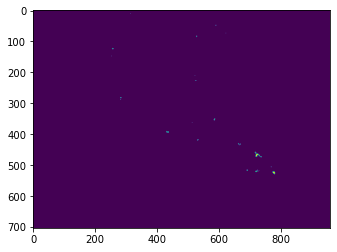


Sample Prediction after epoch 105

Epoch 106/251

 index =  29
247/247 [==============================] - 44s 122ms/step - loss: 0.0073 - accuracy: 0.9948


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


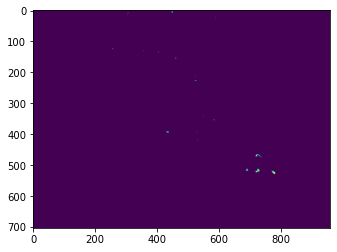


Sample Prediction after epoch 106

Epoch 107/251

 index =  30
247/247 [==============================] - 44s 122ms/step - loss: 0.0049 - accuracy: 0.9983


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


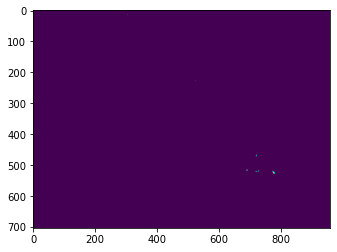


Sample Prediction after epoch 107

Epoch 108/251

 index =  31
247/247 [==============================] - 45s 122ms/step - loss: 3.0544e-04 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


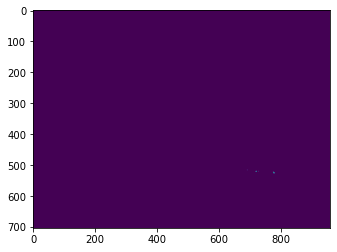


Sample Prediction after epoch 108

Epoch 109/251

 index =  32
247/247 [==============================] - 46s 122ms/step - loss: 3.2632e-05 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


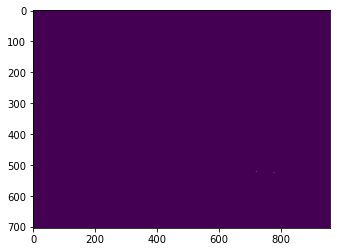


Sample Prediction after epoch 109

Epoch 110/251

 index =  33
247/247 [==============================] - 44s 122ms/step - loss: 6.0761e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


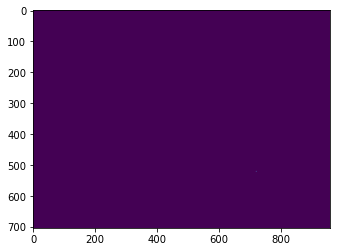


Sample Prediction after epoch 110

Epoch 111/251

 index =  34
247/247 [==============================] - 44s 122ms/step - loss: 3.2681e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


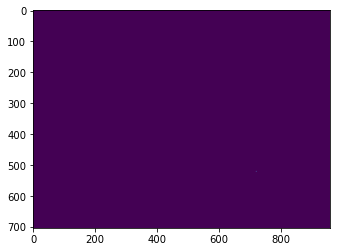


Sample Prediction after epoch 111

Epoch 112/251

 index =  35
247/247 [==============================] - 44s 122ms/step - loss: 1.5582e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


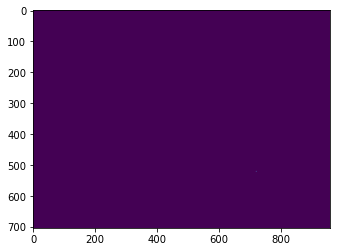


Sample Prediction after epoch 112

Epoch 113/251

 index =  36
247/247 [==============================] - 45s 122ms/step - loss: 1.2948e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


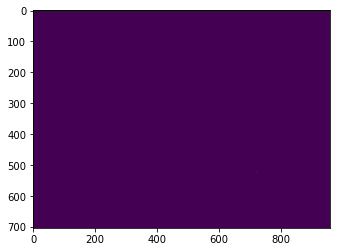


Sample Prediction after epoch 113

Epoch 114/251

 index =  37
247/247 [==============================] - 44s 122ms/step - loss: 9.6580e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


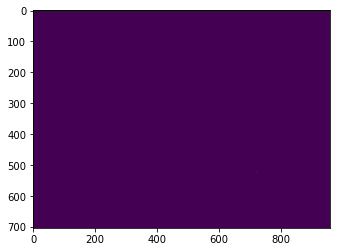


Sample Prediction after epoch 114

Epoch 115/251

 index =  38
247/247 [==============================] - 46s 122ms/step - loss: 5.8248e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


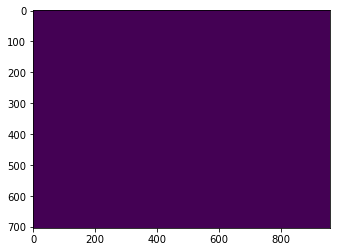


Sample Prediction after epoch 115

Epoch 116/251

 index =  39
247/247 [==============================] - 44s 122ms/step - loss: 5.9365e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


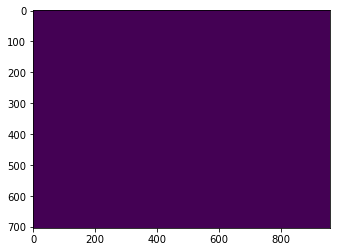


Sample Prediction after epoch 116

Epoch 117/251

 index =  1
247/247 [==============================] - 44s 122ms/step - loss: 0.0674 - accuracy: 0.9716


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


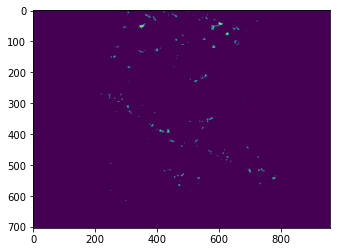


Sample Prediction after epoch 117

Epoch 118/251

 index =  2
247/247 [==============================] - 43s 122ms/step - loss: 0.0431 - accuracy: 0.9750


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


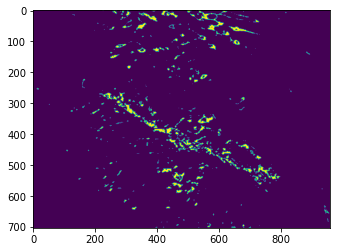


Sample Prediction after epoch 118

Epoch 119/251

 index =  3
247/247 [==============================] - 44s 122ms/step - loss: 0.0285 - accuracy: 0.9795


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


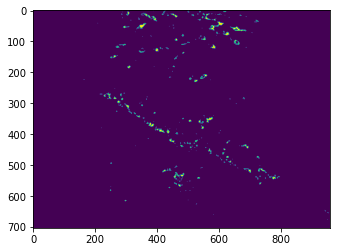


Sample Prediction after epoch 119

Epoch 120/251

 index =  4
247/247 [==============================] - 44s 122ms/step - loss: 0.0192 - accuracy: 0.9843


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


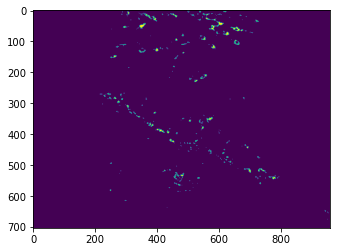


Sample Prediction after epoch 120

Epoch 121/251

 index =  5
247/247 [==============================] - 44s 122ms/step - loss: 0.0177 - accuracy: 0.9860


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


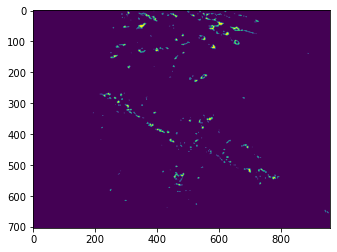


Sample Prediction after epoch 121

Epoch 122/251

 index =  6
247/247 [==============================] - 43s 122ms/step - loss: 0.0118 - accuracy: 0.9899


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


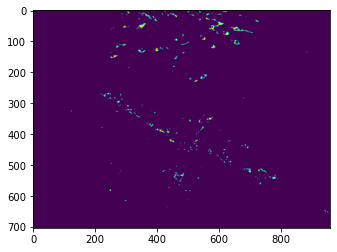


Sample Prediction after epoch 122

Epoch 123/251

 index =  7
247/247 [==============================] - 43s 122ms/step - loss: 0.0065 - accuracy: 0.9940


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


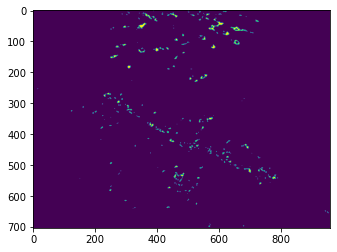


Sample Prediction after epoch 123

Epoch 124/251

 index =  8
247/247 [==============================] - 44s 122ms/step - loss: 0.0045 - accuracy: 0.9958


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


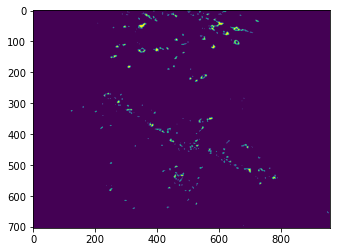


Sample Prediction after epoch 124

Epoch 125/251

 index =  9
247/247 [==============================] - 44s 122ms/step - loss: 0.0055 - accuracy: 0.9950


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


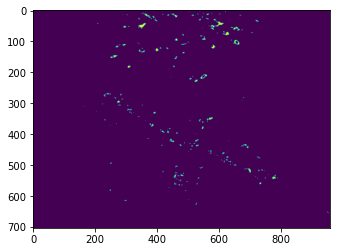


Sample Prediction after epoch 125

Epoch 126/251

 index =  10
247/247 [==============================] - 43s 122ms/step - loss: 0.0056 - accuracy: 0.9944


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


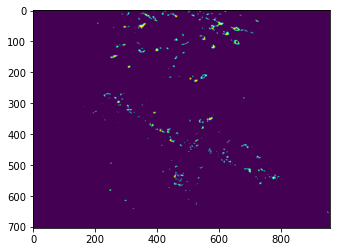


Sample Prediction after epoch 126

Epoch 127/251

 index =  11
247/247 [==============================] - 44s 122ms/step - loss: 0.0042 - accuracy: 0.9954


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


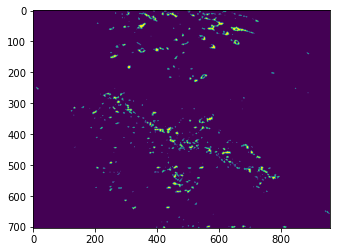


Sample Prediction after epoch 127

Epoch 128/251

 index =  12
247/247 [==============================] - 43s 122ms/step - loss: 0.0132 - accuracy: 0.9933


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


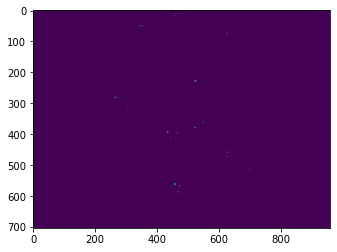


Sample Prediction after epoch 128

Epoch 129/251

 index =  13
247/247 [==============================] - 44s 122ms/step - loss: 0.0159 - accuracy: 0.9892


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


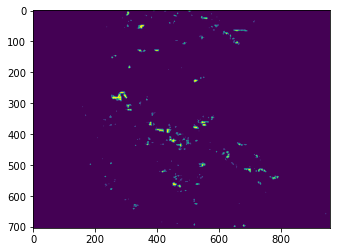


Sample Prediction after epoch 129

Epoch 130/251

 index =  14
247/247 [==============================] - 44s 122ms/step - loss: 0.0178 - accuracy: 0.9886


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


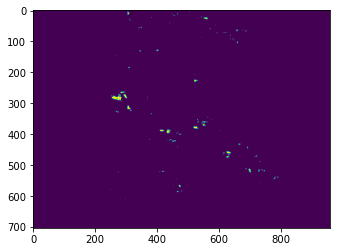


Sample Prediction after epoch 130

Epoch 131/251

 index =  15
247/247 [==============================] - 48s 122ms/step - loss: 0.0166 - accuracy: 0.9872


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


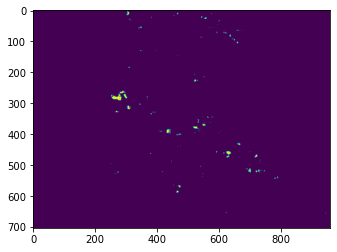


Sample Prediction after epoch 131

Epoch 132/251

 index =  16
247/247 [==============================] - 45s 122ms/step - loss: 0.0175 - accuracy: 0.9894


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


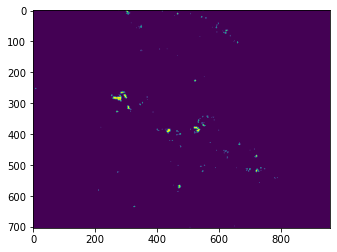


Sample Prediction after epoch 132

Epoch 133/251

 index =  17
247/247 [==============================] - 45s 121ms/step - loss: 0.0238 - accuracy: 0.9843


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


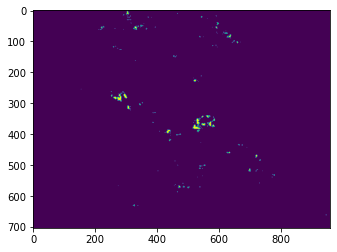


Sample Prediction after epoch 133

Epoch 134/251

 index =  18
247/247 [==============================] - 45s 122ms/step - loss: 0.0401 - accuracy: 0.9691


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


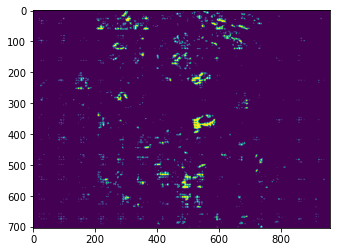


Sample Prediction after epoch 134

Epoch 135/251

 index =  19
247/247 [==============================] - 44s 122ms/step - loss: 0.0408 - accuracy: 0.9607


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


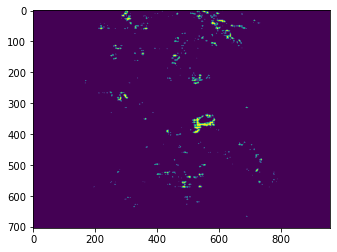


Sample Prediction after epoch 135

Epoch 136/251

 index =  20
247/247 [==============================] - 44s 122ms/step - loss: 0.0254 - accuracy: 0.9632


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


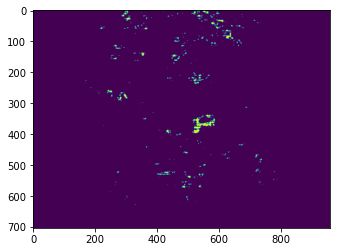


Sample Prediction after epoch 136

Epoch 137/251

 index =  21
247/247 [==============================] - 44s 122ms/step - loss: 0.0232 - accuracy: 0.9732


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


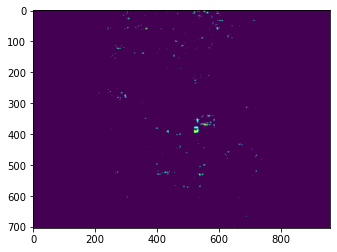


Sample Prediction after epoch 137

Epoch 138/251

 index =  22
247/247 [==============================] - 45s 122ms/step - loss: 0.0229 - accuracy: 0.9877


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


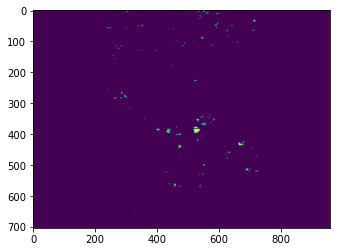


Sample Prediction after epoch 138

Epoch 139/251

 index =  23
247/247 [==============================] - 45s 122ms/step - loss: 0.0179 - accuracy: 0.9922


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


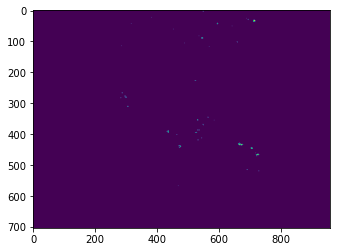


Sample Prediction after epoch 139

Epoch 140/251

 index =  24
247/247 [==============================] - 45s 122ms/step - loss: 0.0195 - accuracy: 0.9911


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


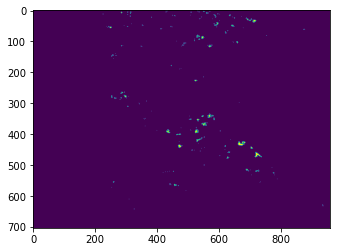


Sample Prediction after epoch 140

Epoch 141/251

 index =  25
247/247 [==============================] - 44s 122ms/step - loss: 0.0132 - accuracy: 0.9933


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


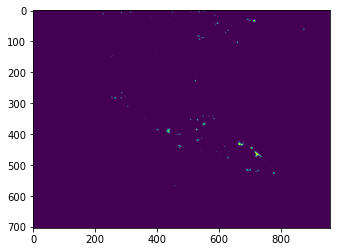


Sample Prediction after epoch 141

Epoch 142/251

 index =  26
247/247 [==============================] - 44s 122ms/step - loss: 0.0151 - accuracy: 0.9939


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


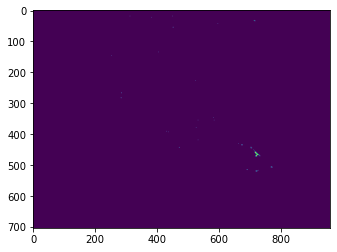


Sample Prediction after epoch 142

Epoch 143/251

 index =  27
247/247 [==============================] - 45s 122ms/step - loss: 0.0113 - accuracy: 0.9937


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


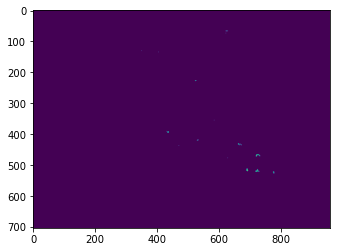


Sample Prediction after epoch 143

Epoch 144/251

 index =  28
247/247 [==============================] - 44s 122ms/step - loss: 0.0071 - accuracy: 0.9940


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


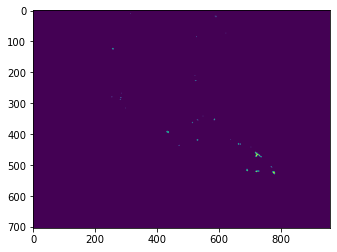


Sample Prediction after epoch 144

Epoch 145/251

 index =  29
247/247 [==============================] - 44s 122ms/step - loss: 0.0068 - accuracy: 0.9946


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


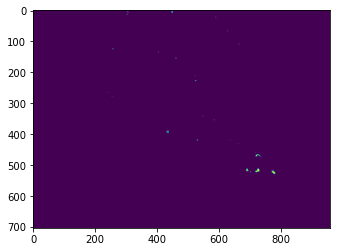


Sample Prediction after epoch 145

Epoch 146/251

 index =  30
247/247 [==============================] - 45s 122ms/step - loss: 0.0047 - accuracy: 0.9982


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


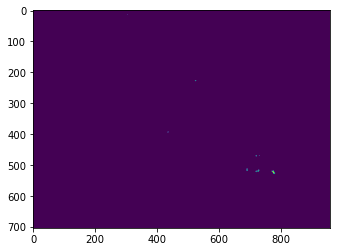


Sample Prediction after epoch 146

Epoch 147/251

 index =  31
247/247 [==============================] - 45s 122ms/step - loss: 2.8811e-04 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


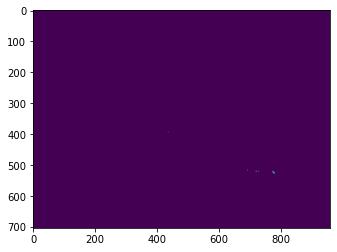


Sample Prediction after epoch 147

Epoch 148/251

 index =  32
247/247 [==============================] - 44s 122ms/step - loss: 3.2670e-05 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


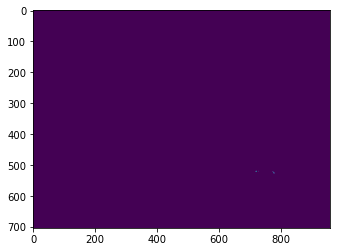


Sample Prediction after epoch 148

Epoch 149/251

 index =  33
247/247 [==============================] - 47s 121ms/step - loss: 4.9040e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


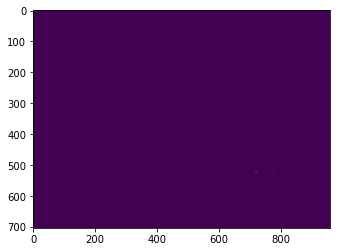


Sample Prediction after epoch 149

Epoch 150/251

 index =  34
247/247 [==============================] - 44s 122ms/step - loss: 2.5377e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


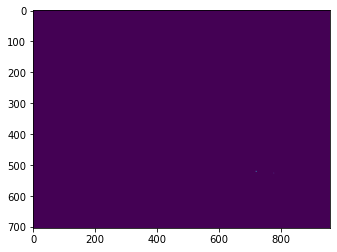


Sample Prediction after epoch 150

Epoch 151/251

 index =  35
247/247 [==============================] - 45s 122ms/step - loss: 1.0248e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


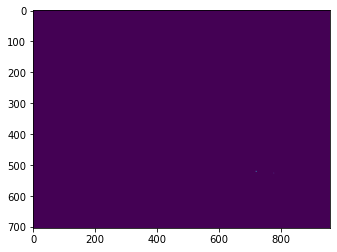


Sample Prediction after epoch 151

Epoch 152/251

 index =  36
247/247 [==============================] - 46s 122ms/step - loss: 1.0973e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


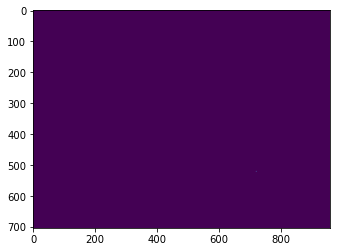


Sample Prediction after epoch 152

Epoch 153/251

 index =  37
247/247 [==============================] - 44s 122ms/step - loss: 7.7697e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


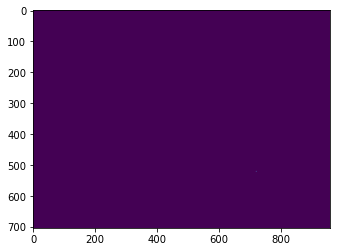


Sample Prediction after epoch 153

Epoch 154/251

 index =  38
247/247 [==============================] - 45s 122ms/step - loss: 4.2925e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


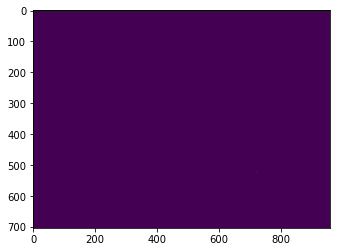


Sample Prediction after epoch 154

Epoch 155/251

 index =  39
247/247 [==============================] - 64s 122ms/step - loss: 4.5925e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


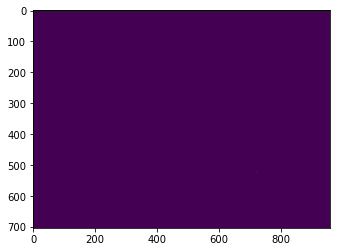


Sample Prediction after epoch 155

Epoch 156/251

 index =  1
247/247 [==============================] - 44s 122ms/step - loss: 0.0652 - accuracy: 0.9715


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


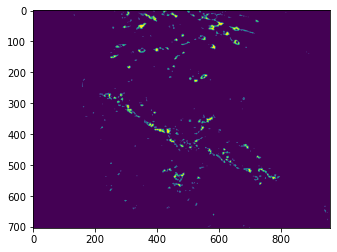


Sample Prediction after epoch 156

Epoch 157/251

 index =  2
247/247 [==============================] - 44s 122ms/step - loss: 0.0423 - accuracy: 0.9741


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


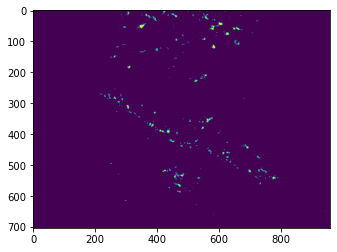


Sample Prediction after epoch 157

Epoch 158/251

 index =  3
247/247 [==============================] - 44s 122ms/step - loss: 0.0274 - accuracy: 0.9801


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


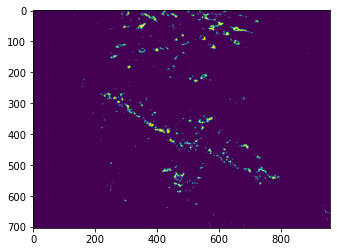


Sample Prediction after epoch 158

Epoch 159/251

 index =  4
247/247 [==============================] - 44s 122ms/step - loss: 0.0191 - accuracy: 0.9842


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


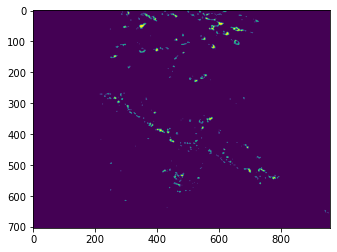


Sample Prediction after epoch 159

Epoch 160/251

 index =  5
247/247 [==============================] - 44s 122ms/step - loss: 0.0165 - accuracy: 0.9857


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


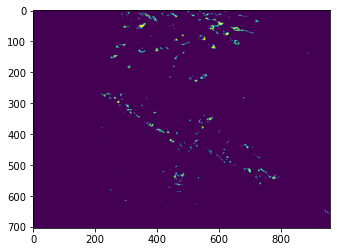


Sample Prediction after epoch 160

Epoch 161/251

 index =  6
247/247 [==============================] - 44s 122ms/step - loss: 0.0115 - accuracy: 0.9898


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


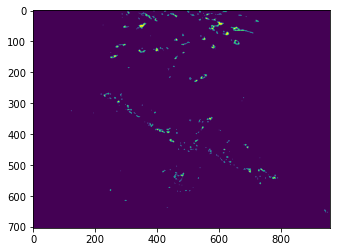


Sample Prediction after epoch 161

Epoch 162/251

 index =  7
247/247 [==============================] - 54s 122ms/step - loss: 0.0063 - accuracy: 0.9939


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


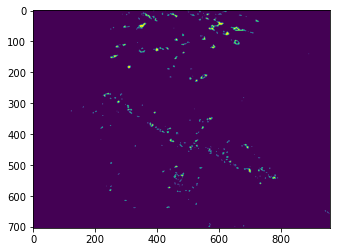


Sample Prediction after epoch 162

Epoch 163/251

 index =  8
247/247 [==============================] - 43s 122ms/step - loss: 0.0044 - accuracy: 0.9958


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


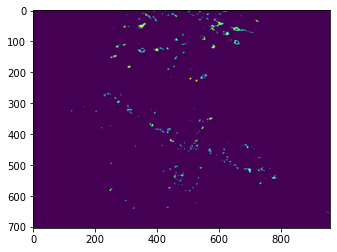


Sample Prediction after epoch 163

Epoch 164/251

 index =  9
247/247 [==============================] - 44s 122ms/step - loss: 0.0053 - accuracy: 0.9949


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


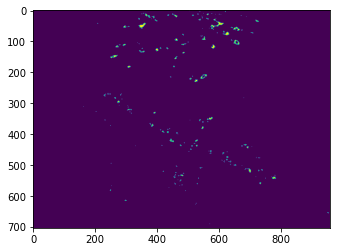


Sample Prediction after epoch 164

Epoch 165/251

 index =  10
247/247 [==============================] - 44s 122ms/step - loss: 0.0055 - accuracy: 0.9943


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


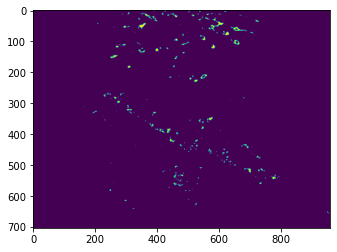


Sample Prediction after epoch 165

Epoch 166/251

 index =  11
247/247 [==============================] - 44s 122ms/step - loss: 0.0040 - accuracy: 0.9954


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


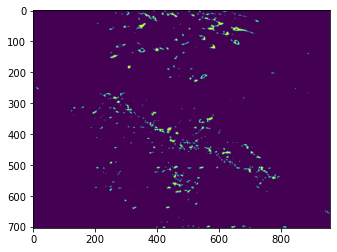


Sample Prediction after epoch 166

Epoch 167/251

 index =  12
247/247 [==============================] - 44s 122ms/step - loss: 0.0124 - accuracy: 0.9932


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


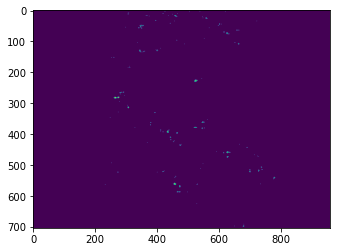


Sample Prediction after epoch 167

Epoch 168/251

 index =  13
247/247 [==============================] - 44s 122ms/step - loss: 0.0147 - accuracy: 0.9892


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


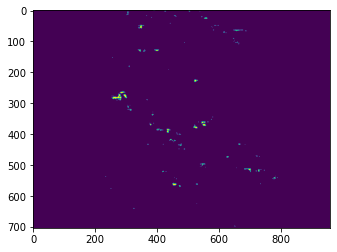


Sample Prediction after epoch 168

Epoch 169/251

 index =  14
247/247 [==============================] - 44s 122ms/step - loss: 0.0153 - accuracy: 0.9878


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


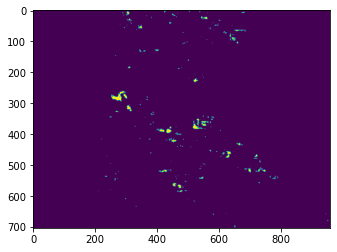


Sample Prediction after epoch 169

Epoch 170/251

 index =  15
247/247 [==============================] - 44s 122ms/step - loss: 0.0160 - accuracy: 0.9876


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


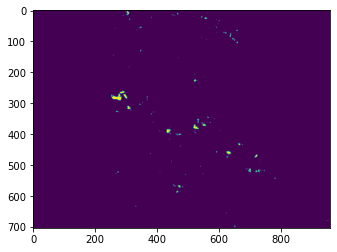


Sample Prediction after epoch 170

Epoch 171/251

 index =  16
247/247 [==============================] - 45s 122ms/step - loss: 0.0181 - accuracy: 0.9888


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


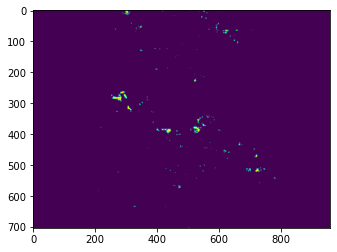


Sample Prediction after epoch 171

Epoch 172/251

 index =  17
247/247 [==============================] - 45s 122ms/step - loss: 0.0213 - accuracy: 0.9848


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


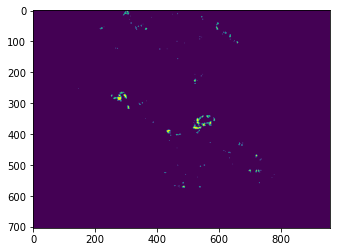


Sample Prediction after epoch 172

Epoch 173/251

 index =  18
247/247 [==============================] - 44s 122ms/step - loss: 0.0303 - accuracy: 0.9687


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


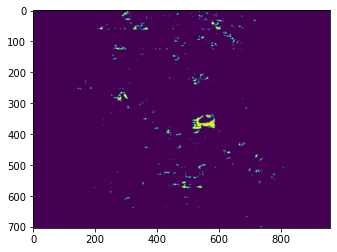


Sample Prediction after epoch 173

Epoch 174/251

 index =  19
247/247 [==============================] - 44s 122ms/step - loss: 0.0495 - accuracy: 0.9599


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


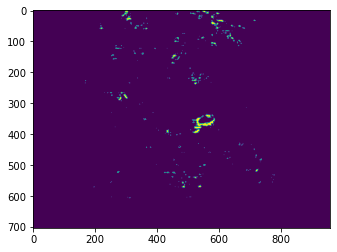


Sample Prediction after epoch 174

Epoch 175/251

 index =  20
247/247 [==============================] - 45s 122ms/step - loss: 0.0221 - accuracy: 0.9631


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


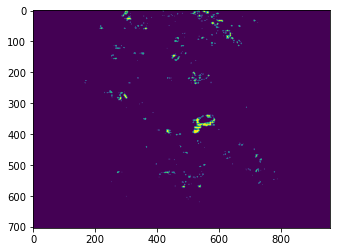


Sample Prediction after epoch 175

Epoch 176/251

 index =  21
247/247 [==============================] - 45s 122ms/step - loss: 0.0209 - accuracy: 0.9730


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


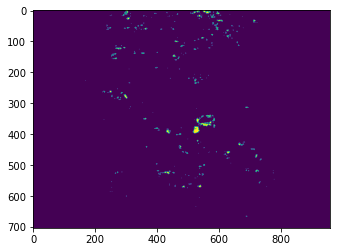


Sample Prediction after epoch 176

Epoch 177/251

 index =  22
247/247 [==============================] - 45s 122ms/step - loss: 0.0194 - accuracy: 0.9867


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


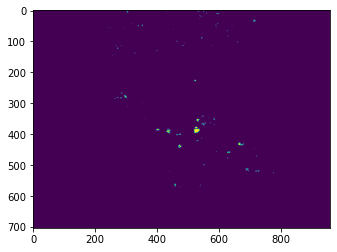


Sample Prediction after epoch 177

Epoch 178/251

 index =  23
247/247 [==============================] - 50s 121ms/step - loss: 0.0159 - accuracy: 0.9921


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


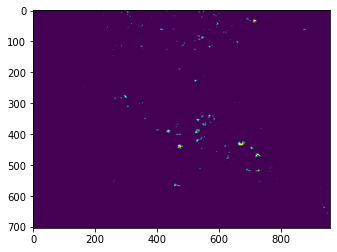


Sample Prediction after epoch 178

Epoch 179/251

 index =  24
247/247 [==============================] - 44s 122ms/step - loss: 0.0181 - accuracy: 0.9903


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


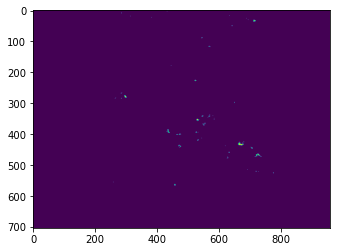


Sample Prediction after epoch 179

Epoch 180/251

 index =  25
247/247 [==============================] - 45s 122ms/step - loss: 0.0123 - accuracy: 0.9932


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


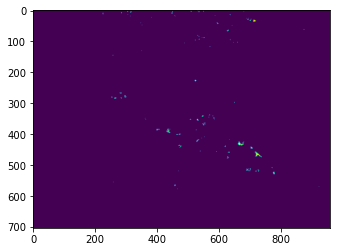


Sample Prediction after epoch 180

Epoch 181/251

 index =  26
247/247 [==============================] - 44s 122ms/step - loss: 0.0142 - accuracy: 0.9937


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


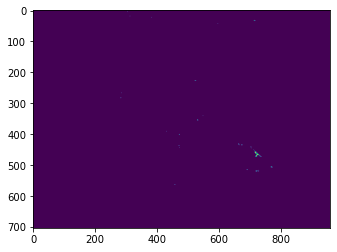


Sample Prediction after epoch 181

Epoch 182/251

 index =  27
247/247 [==============================] - 44s 122ms/step - loss: 0.0105 - accuracy: 0.9934


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


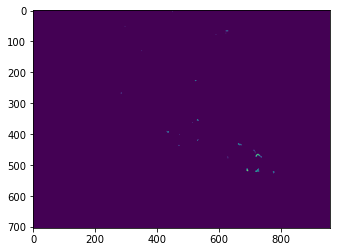


Sample Prediction after epoch 182

Epoch 183/251

 index =  28
247/247 [==============================] - 45s 122ms/step - loss: 0.0067 - accuracy: 0.9939


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


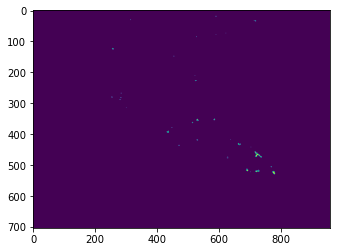


Sample Prediction after epoch 183

Epoch 184/251

 index =  29
247/247 [==============================] - 51s 122ms/step - loss: 0.0063 - accuracy: 0.9944


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


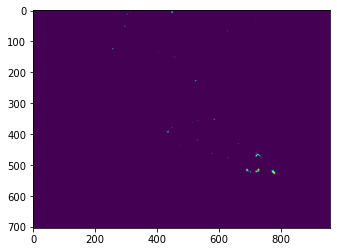


Sample Prediction after epoch 184

Epoch 185/251

 index =  30
247/247 [==============================] - 45s 122ms/step - loss: 0.0046 - accuracy: 0.9982


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


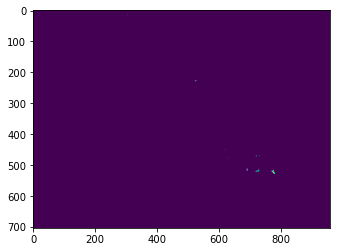


Sample Prediction after epoch 185

Epoch 186/251

 index =  31
247/247 [==============================] - 46s 122ms/step - loss: 2.7470e-04 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


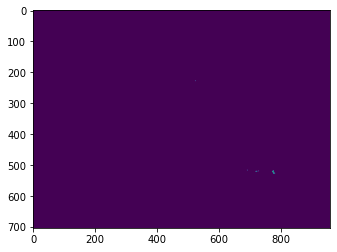


Sample Prediction after epoch 186

Epoch 187/251

 index =  32
247/247 [==============================] - 45s 122ms/step - loss: 3.1475e-05 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


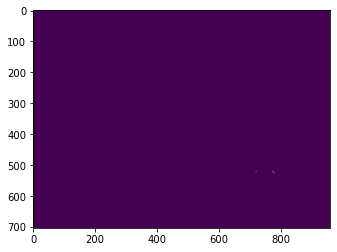


Sample Prediction after epoch 187

Epoch 188/251

 index =  33
247/247 [==============================] - 44s 122ms/step - loss: 3.6463e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


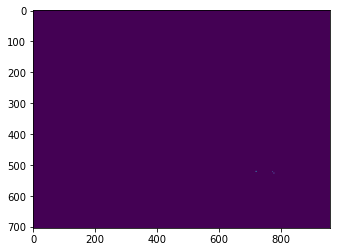


Sample Prediction after epoch 188

Epoch 189/251

 index =  34
247/247 [==============================] - 44s 122ms/step - loss: 1.9455e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


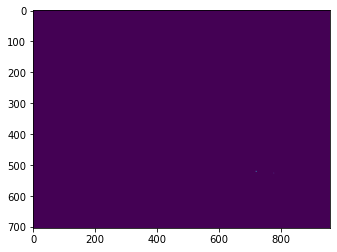


Sample Prediction after epoch 189

Epoch 190/251

 index =  35
247/247 [==============================] - 45s 122ms/step - loss: 9.0339e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


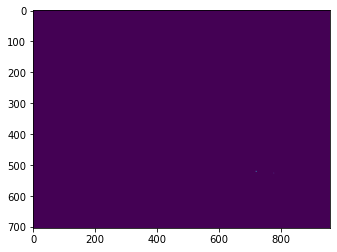


Sample Prediction after epoch 190

Epoch 191/251

 index =  36
247/247 [==============================] - 44s 122ms/step - loss: 8.7551e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


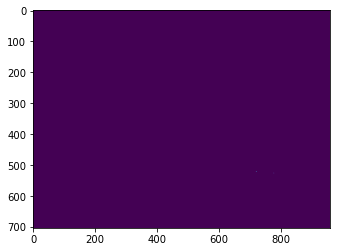


Sample Prediction after epoch 191

Epoch 192/251

 index =  37
247/247 [==============================] - 45s 122ms/step - loss: 6.1948e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


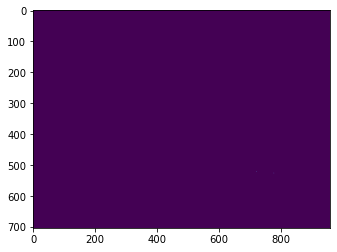


Sample Prediction after epoch 192

Epoch 193/251

 index =  38
247/247 [==============================] - 53s 122ms/step - loss: 2.9650e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


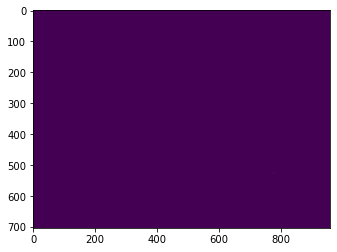


Sample Prediction after epoch 193

Epoch 194/251

 index =  39
247/247 [==============================] - 46s 122ms/step - loss: 3.6413e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


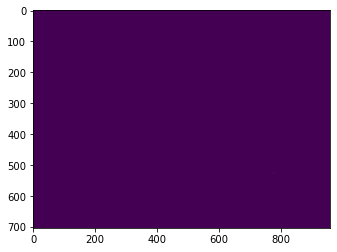


Sample Prediction after epoch 194

Epoch 195/251

 index =  1
247/247 [==============================] - 44s 122ms/step - loss: 0.0677 - accuracy: 0.9706


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


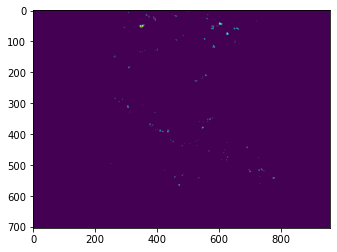


Sample Prediction after epoch 195

Epoch 196/251

 index =  2
247/247 [==============================] - 44s 122ms/step - loss: 0.0379 - accuracy: 0.9751


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


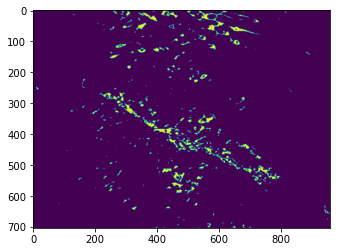


Sample Prediction after epoch 196

Epoch 197/251

 index =  3
247/247 [==============================] - 44s 122ms/step - loss: 0.0264 - accuracy: 0.9793


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


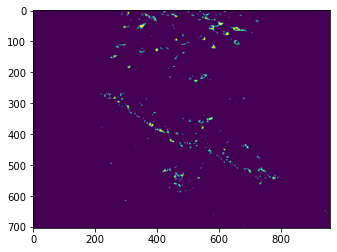


Sample Prediction after epoch 197

Epoch 198/251

 index =  4
247/247 [==============================] - 44s 122ms/step - loss: 0.0181 - accuracy: 0.9841


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


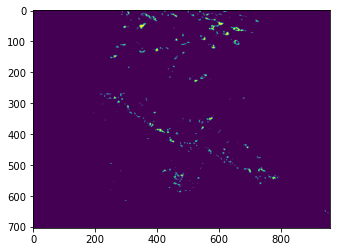


Sample Prediction after epoch 198

Epoch 199/251

 index =  5
247/247 [==============================] - 45s 122ms/step - loss: 0.0167 - accuracy: 0.9858


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


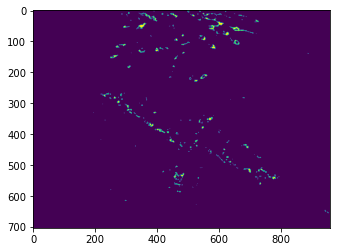


Sample Prediction after epoch 199

Epoch 200/251

 index =  6
247/247 [==============================] - 44s 122ms/step - loss: 0.0112 - accuracy: 0.9897


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


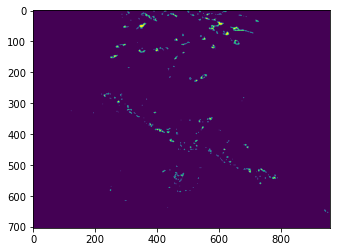


Sample Prediction after epoch 200

Epoch 201/251

 index =  7
247/247 [==============================] - 44s 122ms/step - loss: 0.0062 - accuracy: 0.9939


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


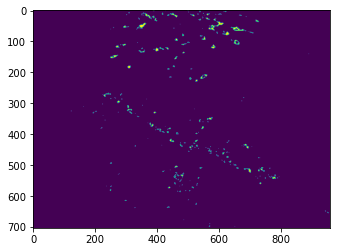


Sample Prediction after epoch 201

Epoch 202/251

 index =  8
247/247 [==============================] - 44s 122ms/step - loss: 0.0043 - accuracy: 0.9958


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


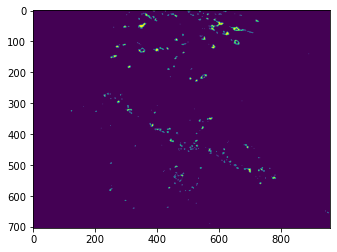


Sample Prediction after epoch 202

Epoch 203/251

 index =  9
247/247 [==============================] - 44s 122ms/step - loss: 0.0052 - accuracy: 0.9949


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


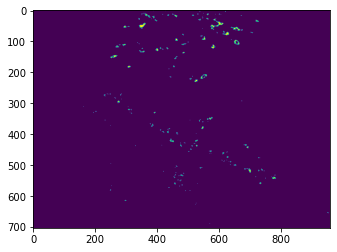


Sample Prediction after epoch 203

Epoch 204/251

 index =  10
247/247 [==============================] - 44s 122ms/step - loss: 0.0054 - accuracy: 0.9943


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


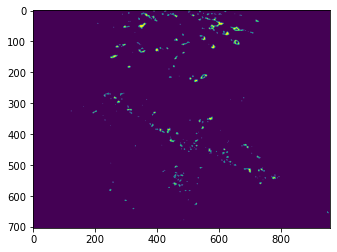


Sample Prediction after epoch 204

Epoch 205/251

 index =  11
247/247 [==============================] - 44s 122ms/step - loss: 0.0038 - accuracy: 0.9954


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


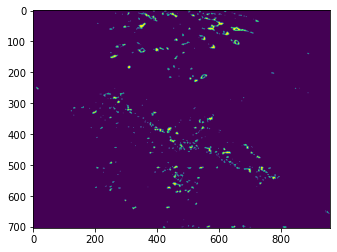


Sample Prediction after epoch 205

Epoch 206/251

 index =  12
247/247 [==============================] - 44s 122ms/step - loss: 0.0113 - accuracy: 0.9932


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


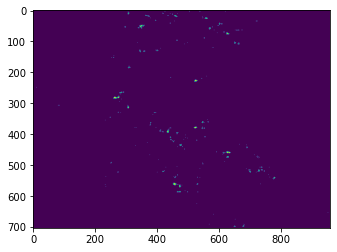


Sample Prediction after epoch 206

Epoch 207/251

 index =  13
247/247 [==============================] - 44s 122ms/step - loss: 0.0134 - accuracy: 0.9890


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


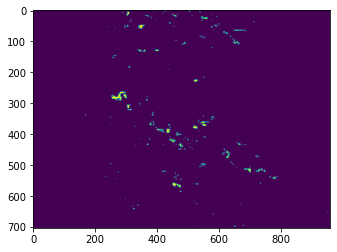


Sample Prediction after epoch 207

Epoch 208/251

 index =  14
247/247 [==============================] - 44s 122ms/step - loss: 0.0157 - accuracy: 0.9882


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


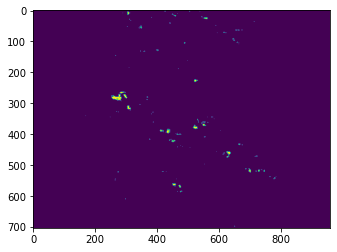


Sample Prediction after epoch 208

Epoch 209/251

 index =  15
247/247 [==============================] - 44s 122ms/step - loss: 0.0150 - accuracy: 0.9868


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


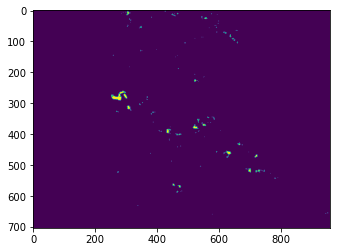


Sample Prediction after epoch 209

Epoch 210/251

 index =  16
247/247 [==============================] - 44s 122ms/step - loss: 0.0136 - accuracy: 0.9888


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


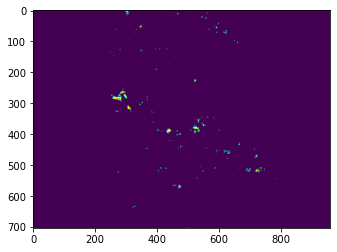


Sample Prediction after epoch 210

Epoch 211/251

 index =  17
247/247 [==============================] - 44s 122ms/step - loss: 0.0170 - accuracy: 0.9839


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


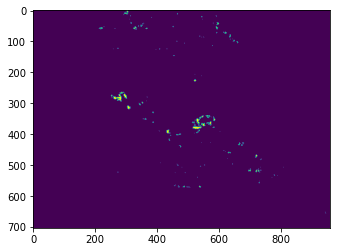


Sample Prediction after epoch 211

Epoch 212/251

 index =  18
247/247 [==============================] - 44s 122ms/step - loss: 0.0332 - accuracy: 0.9690


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


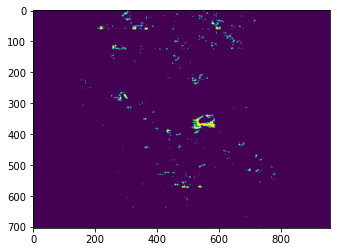


Sample Prediction after epoch 212

Epoch 213/251

 index =  19
247/247 [==============================] - 44s 122ms/step - loss: 0.0403 - accuracy: 0.9595


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


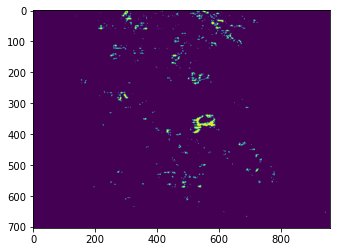


Sample Prediction after epoch 213

Epoch 214/251

 index =  20
247/247 [==============================] - 45s 122ms/step - loss: 0.0240 - accuracy: 0.9627


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


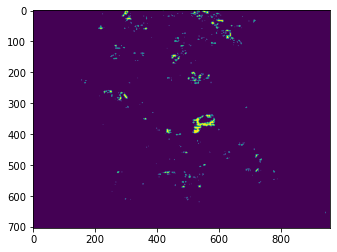


Sample Prediction after epoch 214

Epoch 215/251

 index =  21
247/247 [==============================] - 58s 122ms/step - loss: 0.0253 - accuracy: 0.9728


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


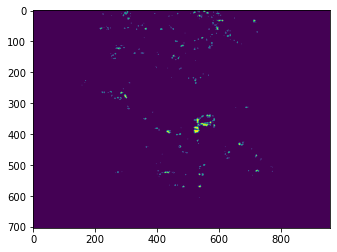


Sample Prediction after epoch 215

Epoch 216/251

 index =  22
247/247 [==============================] - 85s 122ms/step - loss: 0.0175 - accuracy: 0.9866


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


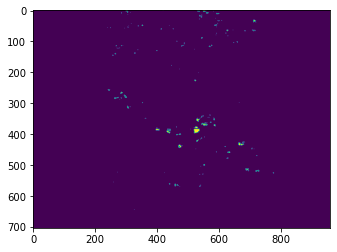


Sample Prediction after epoch 216

Epoch 217/251

 index =  23
247/247 [==============================] - 46s 122ms/step - loss: 0.0160 - accuracy: 0.9915


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


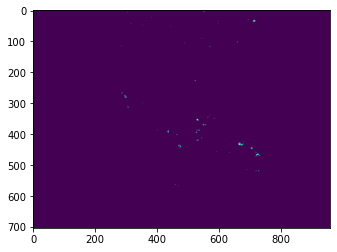


Sample Prediction after epoch 217

Epoch 218/251

 index =  24
247/247 [==============================] - 45s 122ms/step - loss: 0.0177 - accuracy: 0.9905


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


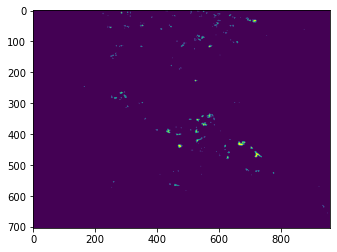


Sample Prediction after epoch 218

Epoch 219/251

 index =  25
247/247 [==============================] - 46s 122ms/step - loss: 0.0119 - accuracy: 0.9928


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


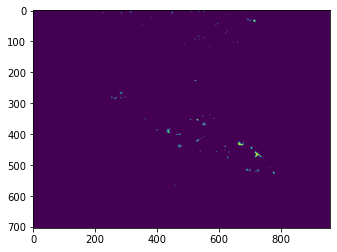


Sample Prediction after epoch 219

Epoch 220/251

 index =  26
247/247 [==============================] - 45s 122ms/step - loss: 0.0135 - accuracy: 0.9935


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


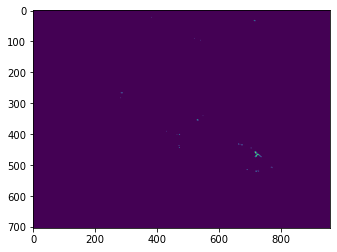


Sample Prediction after epoch 220

Epoch 221/251

 index =  27
247/247 [==============================] - 44s 122ms/step - loss: 0.0101 - accuracy: 0.9933


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


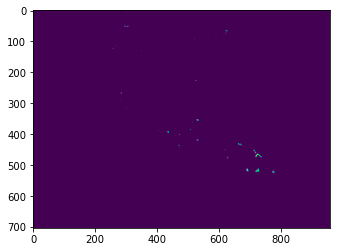


Sample Prediction after epoch 221

Epoch 222/251

 index =  28
247/247 [==============================] - 44s 122ms/step - loss: 0.0065 - accuracy: 0.9938


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


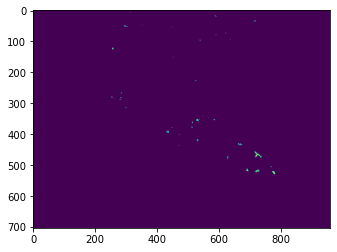


Sample Prediction after epoch 222

Epoch 223/251

 index =  29
247/247 [==============================] - 45s 122ms/step - loss: 0.0065 - accuracy: 0.9943


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


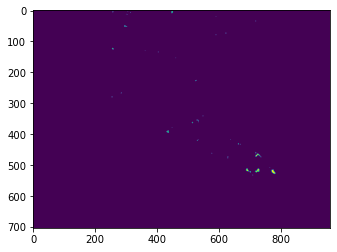


Sample Prediction after epoch 223

Epoch 224/251

 index =  30
247/247 [==============================] - 44s 122ms/step - loss: 0.0039 - accuracy: 0.9981


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


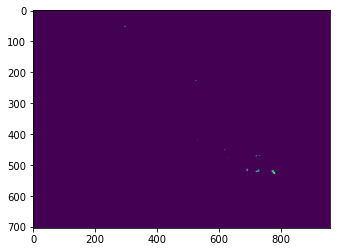


Sample Prediction after epoch 224

Epoch 225/251

 index =  31
247/247 [==============================] - 46s 122ms/step - loss: 2.6979e-04 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


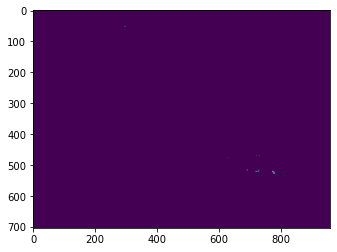


Sample Prediction after epoch 225

Epoch 226/251

 index =  32
247/247 [==============================] - 45s 122ms/step - loss: 2.8840e-05 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


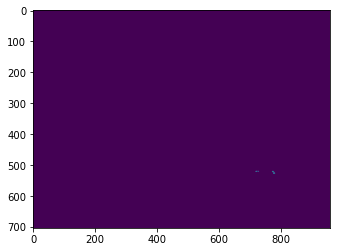


Sample Prediction after epoch 226

Epoch 227/251

 index =  33
247/247 [==============================] - 48s 122ms/step - loss: 2.7913e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


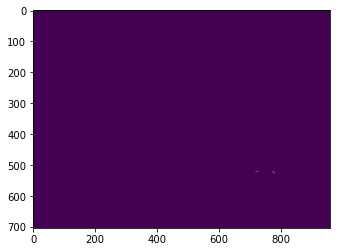


Sample Prediction after epoch 227

Epoch 228/251

 index =  34
247/247 [==============================] - 44s 122ms/step - loss: 1.5675e-06 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


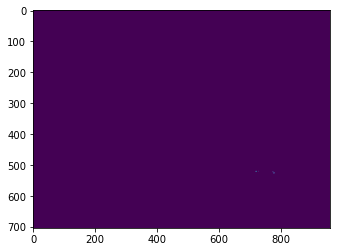


Sample Prediction after epoch 228

Epoch 229/251

 index =  35
247/247 [==============================] - 47s 122ms/step - loss: 8.8281e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


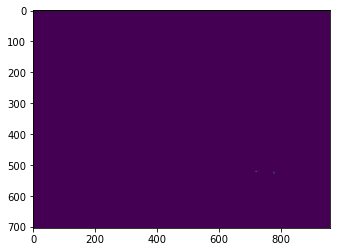


Sample Prediction after epoch 229

Epoch 230/251

 index =  36
247/247 [==============================] - 45s 122ms/step - loss: 9.3566e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


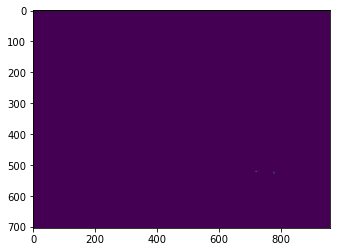


Sample Prediction after epoch 230

Epoch 231/251

 index =  37
247/247 [==============================] - 45s 122ms/step - loss: 5.3756e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


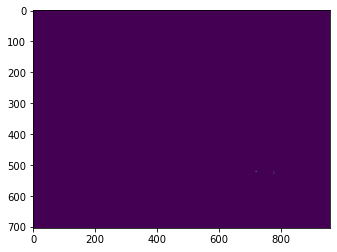


Sample Prediction after epoch 231

Epoch 232/251

 index =  38
247/247 [==============================] - 46s 122ms/step - loss: 2.7077e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


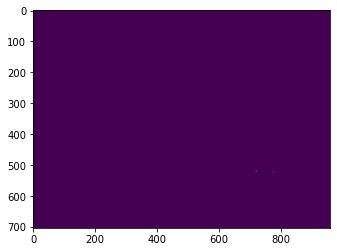


Sample Prediction after epoch 232

Epoch 233/251

 index =  39
247/247 [==============================] - 45s 122ms/step - loss: 3.1690e-07 - accuracy: 1.0000


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


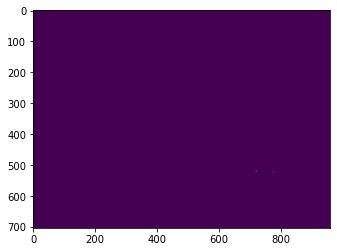


Sample Prediction after epoch 233

Epoch 234/251

 index =  1
247/247 [==============================] - 45s 122ms/step - loss: 0.0733 - accuracy: 0.9708


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


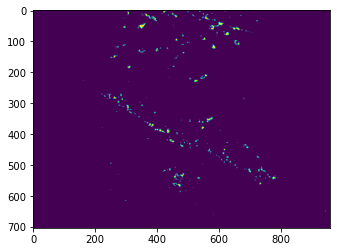


Sample Prediction after epoch 234

Epoch 235/251

 index =  2
247/247 [==============================] - 43s 122ms/step - loss: 0.0316 - accuracy: 0.9746


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


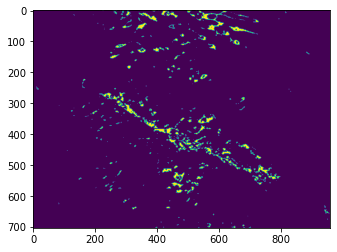


Sample Prediction after epoch 235

Epoch 236/251

 index =  3
247/247 [==============================] - 45s 122ms/step - loss: 0.0254 - accuracy: 0.9792


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


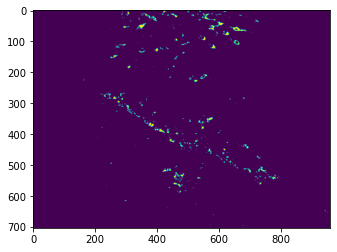


Sample Prediction after epoch 236

Epoch 237/251

 index =  4
247/247 [==============================] - 44s 122ms/step - loss: 0.0178 - accuracy: 0.9841


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


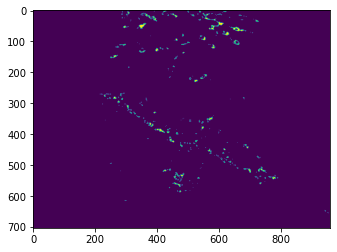


Sample Prediction after epoch 237

Epoch 238/251

 index =  5
247/247 [==============================] - 49s 121ms/step - loss: 0.0163 - accuracy: 0.9857


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


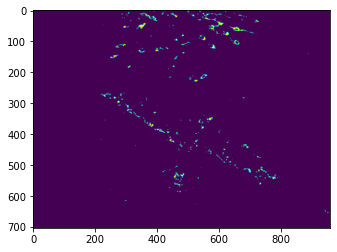


Sample Prediction after epoch 238

Epoch 239/251

 index =  6
247/247 [==============================] - 48s 121ms/step - loss: 0.0111 - accuracy: 0.9897


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


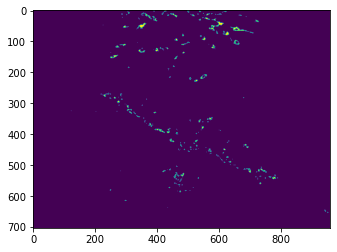


Sample Prediction after epoch 239

Epoch 240/251

 index =  7
247/247 [==============================] - 44s 121ms/step - loss: 0.0061 - accuracy: 0.9939


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


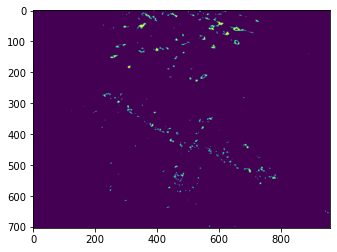


Sample Prediction after epoch 240

Epoch 241/251

 index =  8
247/247 [==============================] - 44s 121ms/step - loss: 0.0042 - accuracy: 0.9958


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


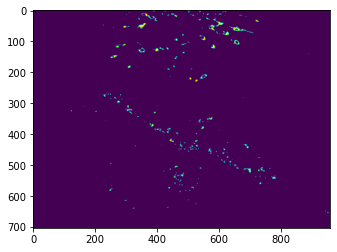


Sample Prediction after epoch 241

Epoch 242/251

 index =  9
247/247 [==============================] - 45s 121ms/step - loss: 0.0051 - accuracy: 0.9948


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


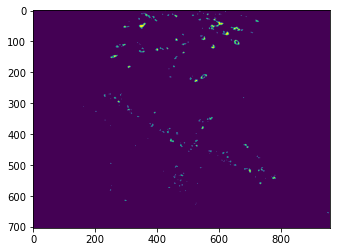


Sample Prediction after epoch 242

Epoch 243/251

 index =  10
247/247 [==============================] - 44s 121ms/step - loss: 0.0053 - accuracy: 0.9943


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


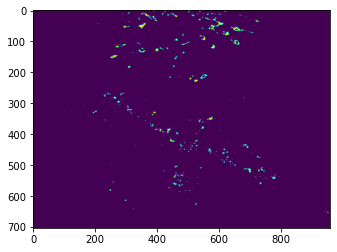


Sample Prediction after epoch 243

Epoch 244/251

 index =  11
247/247 [==============================] - 45s 121ms/step - loss: 0.0038 - accuracy: 0.9954


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


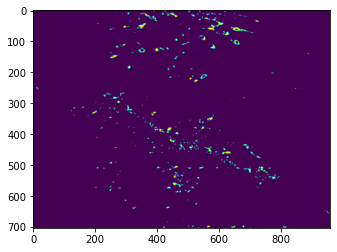


Sample Prediction after epoch 244

Epoch 245/251

 index =  12
247/247 [==============================] - 44s 121ms/step - loss: 0.0102 - accuracy: 0.9932


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


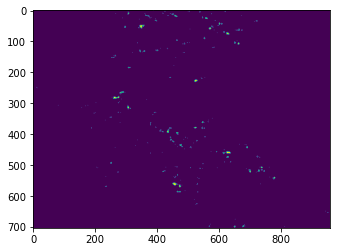


Sample Prediction after epoch 245

Epoch 246/251

 index =  13
247/247 [==============================] - 62s 121ms/step - loss: 0.0120 - accuracy: 0.9889


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


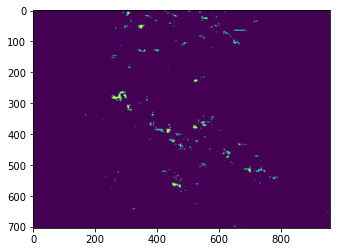


Sample Prediction after epoch 246

Epoch 247/251

 index =  14
247/247 [==============================] - 48s 121ms/step - loss: 0.0150 - accuracy: 0.9881


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


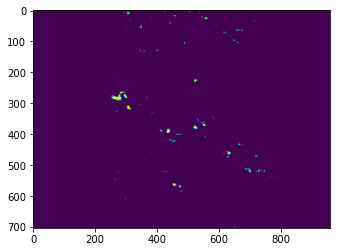


Sample Prediction after epoch 247

Epoch 248/251

 index =  15
247/247 [==============================] - 44s 121ms/step - loss: 0.0148 - accuracy: 0.9867


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


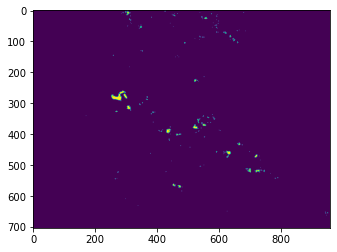


Sample Prediction after epoch 248

Epoch 249/251

 index =  16
247/247 [==============================] - 43s 121ms/step - loss: 0.0125 - accuracy: 0.9884


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


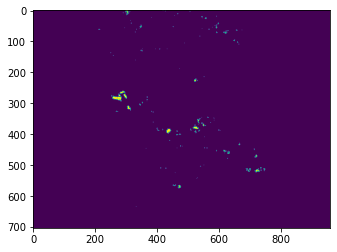


Sample Prediction after epoch 249

Epoch 250/251

 index =  17
247/247 [==============================] - 44s 121ms/step - loss: 0.0201 - accuracy: 0.9844


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


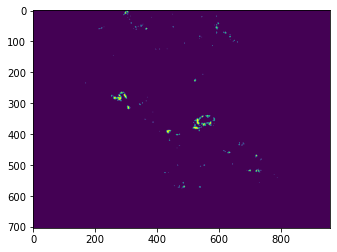


Sample Prediction after epoch 250

Epoch 251/251

 index =  18
247/247 [==============================] - 45s 121ms/step - loss: 0.0298 - accuracy: 0.9683


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


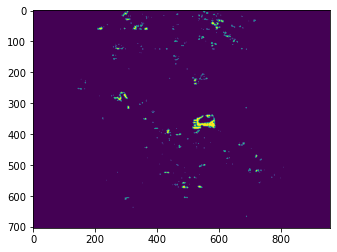


Sample Prediction after epoch 251



In [16]:
model.fit_generator(generator=my_training_batch_generator,
                  epochs=251,
                   verbose = 1,
                   steps_per_epoch =  int(samples_in_file//batch_size), 
                    shuffle=False,
                   callbacks=[DisplayCallback()]
                   )

In [27]:
path_train = "B5.png" 
path_target = "MASK.png" 


100%|██████████| 15/15 [00:00<00:00, 3490.21it/s]


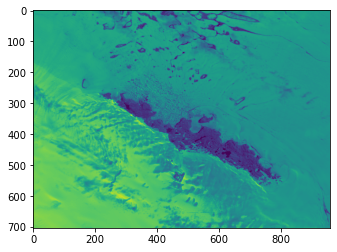

In [28]:
# вывод входящего изображения 
test_image, test_image_size = split_image_old(path_train, size)
img = Image.new('L', (size*test_image_size[0], size*test_image_size[1]))

for i in tqdm(range(test_image_size[0])):
    for j in range(test_image_size[1]):

        train_img = np.reshape(test_image[i * test_image_size[1] + j], (size, size)) 
        a = train_img.astype('uint8') 
        img1 =  Image.fromarray(a)
        img.paste(img1, (i*size, j*size))
        
img.save("2.png")
plt.imshow(img) 

100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


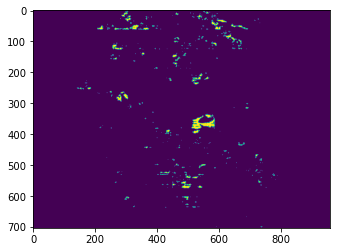

In [37]:
# вывод и сохранение предсказания
path = "B5.png" 
size = 64
test_image, test_image_size = split_image_old(path, size) 
test_image = test_image / 255.0

img = Image.new('L', (size*test_image_size[0], size*test_image_size[1]))

for i in tqdm(range(test_image_size[0])):
    for j in range(test_image_size[1]):

        a = test_image[i * test_image_size[1] + j]
        a = np.repeat(a, 3)        
        b = np.reshape(a, (1, size, size, 3))
        prediction = model.predict(b)
        prediction = prediction # * 10000

#         b, c = np.array_split(prediction, 2, axis = 3)
        train_img = create_mask(prediction)
        train_img = np.array(train_img) 

        train_img = np.reshape(train_img, (size, size )) 
        a = train_img.astype('uint8') 
        a = a * 256
        img1 =  Image.fromarray(a)
        img.paste(img1, (i*size, j*size))

plt.imshow(img) 
plt.show()
img.save("18.png")

In [38]:
# визуализация вывода сети

In [39]:
a = Image.open("2.png").convert('RGB')
b = Image.open("18.png") 

In [40]:
a = np.asarray(a)
a = a.copy()

In [41]:
b = np.asarray(b)
b = b.copy()

In [42]:
for i in range(np.shape(a)[0]):
    for j in range(np.shape(a)[1]):
        a[i,j] = [a[i][j][0], b[i][j] if b[i][j] else a[i][j][1], a[i][j][2]]

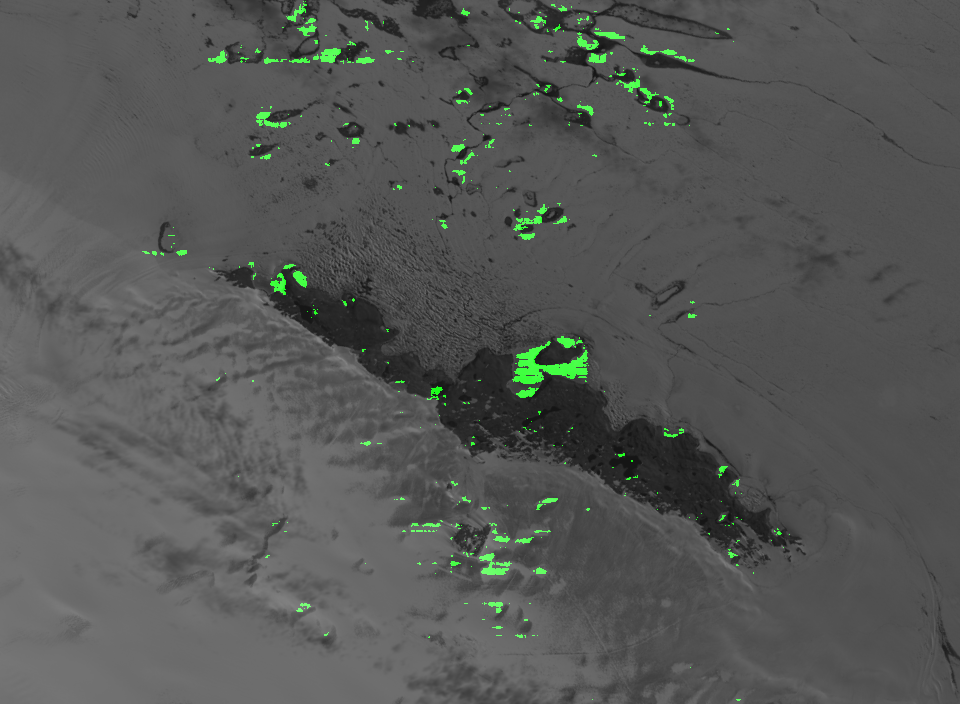

In [43]:
img1 = Image.fromarray(a)
img1

In [25]:
img1.save("18_color.png")

In [35]:
model_name = "model_unet_like_best_3_inp=64_B5_dataset_2"

In [18]:
path = f'models/{model_name}.h5'
model.save(path)  

/home/valter/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [36]:
path = f'models/{model_name}.h5'
model = tf.keras.models.load_model(path)